In [1]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import random
import collections
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer
import re
import itertools


import os
import gzip
import json
import time

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Helper libraries
from common import utils, vocabulary, models

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib inline
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import surprise
from surprise.model_selection import KFold, train_test_split, GridSearchCV, cross_validate

from surprise import SVD, SVDpp, NMF, KNNBaseline, similarities
from surprise import Dataset
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import Reader
from surprise import accuracy

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df_ = {}
    for d in parse(path):
        df_[i] = d
        i += 1
    return pd.DataFrame.from_dict(df_, orient='index')

In [5]:
# reviews_Toys_and_Games.json.gz
print("Loading Toys and Games Review dataset:")
print()
# _f = 'reviews_Toys_and_Games_5.json.gz'
_f = 'reviews_Toys_and_Games.json.gz'

start = time.time()
fd = getDF(_f)
print('Total time taken for loading the full toys and games reviews dataset : {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(fd.columns)

print()
fd.head(1)

Loading Toys and Games Review dataset:

Total time taken for loading the full toys and games reviews dataset : 2.0 minutes.

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5.0,Puzzles,1388016000,"12 26, 2013"


In [6]:
df_fd = fd[['reviewerID', 'asin','overall']]
df_fd['date'] = pd.to_datetime(fd['reviewTime'])
df_fd['month'] = pd.to_datetime(fd['reviewTime']).dt.month
df_fd['year'] = pd.to_datetime(fd['reviewTime']).dt.year
df_fd.sort_values(by = 'date', inplace = True)

/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

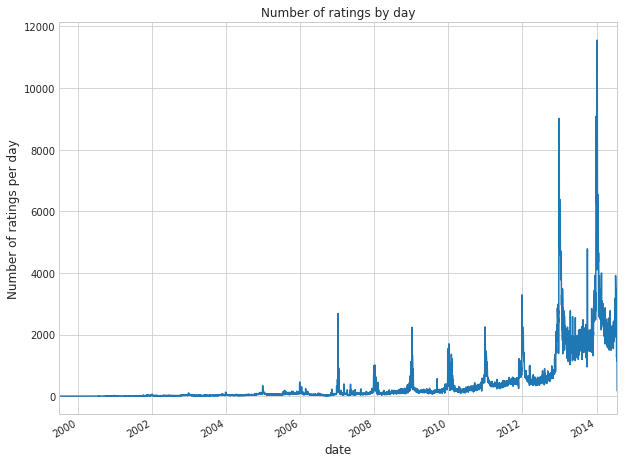

In [7]:
plt.figure(figsize = (10,8))

ax = df_fd.groupby(by = 'date')['overall'].count().plot()
ax.set_title("Number of ratings by day", fontsize = 12)
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Number of ratings per day", fontsize = 12)
plt.tick_params(labelsize = 10)
plt.show()

In [8]:
print("In the original dataset:")
print("------------------------")
print("Number of records: {:,}".format(len(df_fd)))
print("Unique users: {:,}".format(df_fd.reviewerID.nunique()))
print("Unique items: {:,}".format(df_fd.asin.nunique()))
print()
print("After 2007:")
print("-----------")
print("Number of records in the split after 2007: {:,}".format(len(df_fd[df_fd.year.values >= 2007])))
print("Unique users:  {:,}".format(df_fd[df_fd.year.values >= 2007].reviewerID.nunique()))
print("Unique items:  {:,}".format(df_fd[df_fd.year.values >= 2007].asin.nunique()))
print()
print("Before 2012:")
print("------------")
print("Number of records in the split before 2012: {:,}".format(len(df_fd[df_fd.year.values < 2012])))
print("Unique users: {:,}".format(df_fd[df_fd.year.values < 2012].reviewerID.nunique()))
print("Unique items: {:,}".format(df_fd[df_fd.year.values < 2012].asin.nunique()))
print()
print("After 2012:")
print("-----------")
print("Number of records in the split after 2012: {:,}".format(len(df_fd[df_fd.year.values >= 2012])))
print("Unique users: {:,}".format(df_fd[df_fd.year.values >= 2012].reviewerID.nunique()))
print("Unique items: {:,}".format(df_fd[df_fd.year.values >= 2012].asin.nunique()))
print()
print("Common to before and after splits:")
print("----------------------------------")
print("Products - {:,}".format(len(set(df_fd[df_fd.year.values < 2012].asin.unique()).intersection(df_fd[df_fd.year.values >= 2012].asin.unique()))))
print("Users - {:,}".format(len(set(df_fd[df_fd.year.values < 2012].reviewerID.unique()).intersection(df_fd[df_fd.year.values >= 2012].reviewerID.unique()))))

In the original dataset:
------------------------
Number of records: 2,252,771
Unique users: 1,342,911
Unique items: 327,698

After 2007:
-----------
Number of records in the split after 2007: 2,161,194
Unique users:  1,285,926
Unique items:  322,343

Before 2012:
------------
Number of records in the split before 2012: 584,704
Unique users: 397,993
Unique items: 124,001

After 2012:
-----------
Number of records in the split after 2012: 1,668,067
Unique users: 1,005,856
Unique items: 268,790

Common to before and after splits:
----------------------------------
Products - 65,093
Users - 60,938


In [9]:
print("Between 2012 & 2014:")
print("--------------------")
print("Number of records in the split after 2012 7 before 2014: {:,}".format(len(df_fd[(df_fd.year.values >= 2012) & (df_fd.year.values < 2014)])))
print("Unique users: {:,}".format(df_fd[(df_fd.year.values >= 2012) & (df_fd.year.values < 2014)].reviewerID.nunique()))
print("Unique items: {:,}".format(df_fd[(df_fd.year.values >= 2012) & (df_fd.year.values < 2014)].asin.nunique()))
print()
print("In 2014:")
print("--------")
print("Number of records in the split in 2014: {:,}".format(len(df_fd[df_fd.year.values >= 2014])))
print("Unique users: {:,}".format(df_fd[df_fd.year.values >= 2014].reviewerID.nunique()))
print("Unique items: {:,}".format(df_fd[df_fd.year.values >= 2014].asin.nunique()))
print()

Between 2012 & 2014:
--------------------
Number of records in the split after 2012 7 before 2014: 1,105,949
Unique users: 691,494
Unique items: 211,523

In 2014:
--------
Number of records in the split in 2014: 562,118
Unique users: 374,113
Unique items: 140,618



In [10]:
if os.path.isfile("filtered.csv"):
    fd_filtered_ = pd.read_csv("filtered.csv")
else:
    
    # Get the count of each value within the dataset

    
    start = time.time()
    
    reviewlist = review_counts_5.index.tolist()
    itemlist = item_counts_5.index.tolist()

    condition = fd['reviewerID'].isin(reviewlist)
    fd_filtered = fd[condition].reset_index(drop=True)
    print(len(fd_filtered))
    
    print("time taken to filter users with at least 5 user reviews:", time.time() - start)
    
    start = time.time()
    condition_ = fd_filtered['asin'].isin(itemlist)
    fd_filtered_ = fd_filtered[condition_].reset_index(drop=True)
    print(len(fd_filtered_))
    print("time taken to filter users and items with at least 5 reviews each:", np.round(time.time() - start,2), "seconds.")
    print()

fd_filtered_.head()

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0,AYVR1MQCTNU5D,0375829695,annie,"[0, 0]",What a great theme for a puzzle book. My daugh...,5.0,So cute!!,1291939200,"12 10, 2010"
1,1,A3638FINP26E8N,0375829695,C. Boykin,"[1, 1]",Love the book format. My 4yr old grandson love...,3.0,frustrating puzzle pieces,1282521600,"08 23, 2010"
2,2,A11TL78PNBS336,0375829695,"L. Vickers ""lcvickers""","[0, 0]","If you have a child who loves Dr. Suess, and l...",4.0,Big book of puzzles!,1292198400,"12 13, 2010"
3,3,A12PP78XFH8LCZ,0439855896,4grandma,"[0, 1]",Should have read other product reviews before ...,2.0,Magic Wand,1376956800,"08 20, 2013"
4,4,A2NYUQM7MKANW0,0439855896,"Creyu Suda ""Creyu Suda""","[1, 1]","It is a rolled up piece of paper, and yes it i...",5.0,All the one star reviews are true; the wand it...,1393372800,"02 26, 2014"


In [11]:
fd_filtered_['date'] = pd.to_datetime(fd_filtered_['reviewTime'])
fd_filtered_['month'] = pd.to_datetime(fd_filtered_['reviewTime']).dt.month
fd_filtered_['year'] = pd.to_datetime(fd_filtered_['reviewTime']).dt.year
fd_filtered_.sort_values(by = 'date', inplace = True)

In [12]:
fd_filtered_train = fd_filtered_[(fd_filtered_.year.values >= 2012) & (fd_filtered_.year.values < 2014)]
fd_filtered_val = fd_filtered_[fd_filtered_.year.values >= 2014]

In [13]:
print("Number of records in the training set split after 2012 & before 2014: {:,}".format(len(fd_filtered_train)))
print("Unique users: {:,}".format(fd_filtered_train.reviewerID.nunique()))
print("Unique items: {:,}".format(fd_filtered_train.asin.nunique()))
print()
print("In 2014:")
print("--------")
print("Number of records in the validation set split in 2014: {:,}".format(len(fd_filtered_val)))
print("Unique users: {:,}".format(fd_filtered_val.reviewerID.nunique()))
print("Unique items: {:,}".format(fd_filtered_val.asin.nunique()))
print()

Number of records in the training set split after 2012 & before 2014: 216,635
Unique users: 43,748
Unique items: 50,281

In 2014:
--------
Number of records in the validation set split in 2014: 96,096
Unique users: 26,992
Unique items: 32,996



In [14]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

In [15]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(fd_filtered_[fd_filtered_.year.values >= 2012][['reviewerID', 'asin', 'overall']], reader)
data_train = Dataset.load_from_df(fd_filtered_train[['reviewerID', 'asin', 'overall']], reader)
data_val = Dataset.load_from_df(fd_filtered_val[['reviewerID', 'asin', 'overall']], reader)

In [16]:
# Load the full dataset.
raw_ratings = data.raw_ratings

# shuffle ratings if you want
# random.shuffle(raw_ratings)

# A = 80% of the data, B = 20% of the data
# threshold = int(.8 * len(raw_ratings))
# A_raw_ratings = raw_ratings[:threshold]
# B_raw_ratings = raw_ratings[threshold:]
A_raw_ratings = data_train.raw_ratings
B_raw_ratings = data_val.raw_ratings

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print('Grid Search...')

start = time.time()

param_grid = {'n_epochs':[10], 'n_factors': [10, 40], 'lr_all': [0.001, 0.005, 0.01, 0.1],
              'reg_all': [0.01, 0.02, 0.05, 0.1]}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

algo = grid_search.best_estimator['rmse']

# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

print()

Grid Search...
Biased accuracy on A,   RMSE: 0.7918
Unbiased accuracy on B, RMSE: 0.9680



In [17]:
# meta_Toys_and_Games.json.gz
print("Loading related metadata dataset:")
print()
# file = 'metadata.json.gz'
file = 'meta_Toys_and_Games.json.gz'
start = time.time()
fd_ = getDF(file)
print('Total time taken for loading the metadata dataset: {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(fd_.columns)
print()

print(fd_.head(1))

Loading related metadata dataset:

Total time taken for loading the metadata dataset: 1.0 minutes.

Index(['asin', 'description', 'title', 'price', 'salesRank', 'imUrl', 'brand',
       'categories', 'related'],
      dtype='object')

         asin                                        description  \
0  0000191639  Three Dr. Suess' Puzzles: Green Eggs and Ham, ...   

                                            title  price  \
0  Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle  37.12   

                  salesRank  \
0  {'Toys & Games': 612379}   

                                               imUrl      brand  \
0  http://ecx.images-amazon.com/images/I/414PLROX...  Dr. Seuss   

                                  categories related  
0  [[Toys & Games, Puzzles, Jigsaw Puzzles]]     NaN  


In [18]:
print("Merging filtered Toys & Games dataset and the related metadata datsset:")
print()
dframe = pd.merge(fd_filtered_[fd_filtered_.year.values >= 2012], fd_, on=['asin'], how='inner')

print("Full, unfiltered Toys & Games dataset:")
print()
print("Number of records: {:,}".format(len(fd)))
print("Number of unique reviewerIDs: {:,}".format(fd.reviewerID.nunique()))
print("Number of unique items: {:,}".format(fd.asin.nunique()))
print()
print("Filtered Toys & Games dataset = with at least 5 user reviews and items with at least 5 reviews:")
print()
print("Number of records: {:,}".format(len(fd_filtered_[fd_filtered_.year.values >= 2012])))
print("Number of unique reviewerIDs: {:,}".format(fd_filtered_[fd_filtered_.year.values >= 2012].reviewerID.nunique()))
print("Number of unique items: {:,}".format(fd_filtered_[fd_filtered_.year.values >= 2012].asin.nunique()))
print()

print("Metadata:")
print("Number of records: {:,}".format(len(fd_)))
print("Metadata dataset has no attribute called 'reviewerID'")
print("Number of unique items: {:,}".format(fd_.asin.nunique()))
print()

print("Merged dataset = filtered Toys and Games dataset + metadata dataset:")
print("The number of records: {:,}".format(len(dframe)))
print("Number of unique reviewerID: {:,}".format(dframe.reviewerID.nunique()))
print("Number of unique items: {:,}".format(dframe.asin.nunique()))

print()

dframe.head(1)

Merging filtered Toys & Games dataset and the related metadata datsset:

Full, unfiltered Toys & Games dataset:

Number of records: 2,252,771
Number of unique reviewerIDs: 1,342,911
Number of unique items: 327,698

Filtered Toys & Games dataset = with at least 5 user reviews and items with at least 5 reviews:

Number of records: 312,731
Number of unique reviewerIDs: 51,557
Number of unique items: 58,211

Metadata:
Number of records: 336,072
Metadata dataset has no attribute called 'reviewerID'
Number of unique items: 336,072

Merged dataset = filtered Toys and Games dataset + metadata dataset:
The number of records: 312,731
Number of unique reviewerID: 51,557
Number of unique items: 58,211



,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,...,month,year,description,title,price,salesRank,imUrl,brand,categories,related
0,240555,A18CZOIMO2PFVE,B004JIL6G6,Val,"[0, 0]",My two children (ages 5 and 7) had a lot of fu...,4.0,Great Christmas craft activity!,1325376000,"01 1, 2012",...,1,2012,Transform this velvet-flocked tree into a fun ...,Creativity For Kids Shrinky Dinks Christmas Tree,11.24,{'Toys & Games': 84242},http://ecx.images-amazon.com/images/I/61T2VzyZ...,Creativity for Kids,"[[Toys & Games, Arts & Crafts, Craft Kits, Jew...","{'also_bought': ['B007QNDWB8', 'B000UEDTWC', '..."


In [19]:
print()
print("Number of NaN values in the merged dataset: \n", dframe.isnull().sum())


Number of NaN values in the merged dataset: 
 Unnamed: 0            0
reviewerID            0
asin                  0
reviewerName       1739
helpful               0
reviewText          118
overall               0
summary               0
unixReviewTime        0
reviewTime            0
date                  0
month                 0
year                  0
description        6181
title              1605
price             14891
salesRank          8120
imUrl               464
brand             43699
categories            0
related            2044
dtype: int64


In [20]:
# Filtering records with either blank strings or NaN values for 'reviewText'
dframe = dframe[(dframe.reviewText.values != '') & (~(dframe.reviewText.isnull()))].reset_index(drop=True)
print("Records with either blank strings or NaN values for 'reviewText'{:,}".format(len(dframe)))

Records with either blank strings or NaN values for 'reviewText'312,613


In [21]:
print("Missing {:,} values for 'imUrl'".format(dframe[dframe['imUrl'].isnull()].asin.nunique()))
print("Missing {:,} values for 'related'".format(dframe[dframe['related'].isnull()].asin.nunique()))
print("Missing {:,} values for 'categories'".format(dframe[dframe['categories'].isnull()].asin.nunique()))
print("Missing {:,} values for 'price'".format(dframe[dframe['price'].isnull()].asin.nunique()))

Missing 85 values for 'imUrl'
Missing 823 values for 'related'
Missing 0 values for 'categories'
Missing 6,471 values for 'price'


In [22]:
print()
print("Missing {:,} values from imUrl OR categories OR related OR price".format(len(dframe[dframe['imUrl'].isnull() | dframe['categories'].isnull() | dframe['related'].isnull() | dframe['price'].isnull()])))
print()
print("Missing {:,} values from imUrl & categories & related & price".format(len(dframe[dframe['imUrl'].isnull() & dframe['categories'].isnull() & dframe['related'].isnull() & dframe['price'].isnull()])))
print("Missing {:,} values from imUrl & categories & related".format(len(dframe[dframe['imUrl'].isnull() & dframe['categories'].isnull() & dframe['related'].isnull()])))
print("Missing {:,} values from imUrl & related & price".format(len(dframe[dframe['imUrl'].isnull() & dframe['related'].isnull() & dframe['price'].isnull()])))
print("Missing {:,} values from categories & related & price".format(len(dframe[dframe['categories'].isnull() & dframe['related'].isnull() & dframe['price'].isnull()])))
print("Missing {:,} values from related & price".format(len(dframe[dframe['related'].isnull() & dframe['price'].isnull()])))
print()
print("Missing {:,} values from imUrl & categories".format(len(dframe[dframe['imUrl'].isnull() & dframe['categories'].isnull()])))
print("Missing {:,} values from imUrl & related".format(len(dframe[dframe['imUrl'].isnull() & dframe['related'].isnull()])))
print("Missing {:,} values from imUrl & price".format(len(dframe[dframe['imUrl'].isnull() & dframe['price'].isnull()])))
print()
print("Missing {:,} values from categories & related".format(len(dframe[dframe['categories'].isnull() & dframe['related'].isnull()])))
print("Missing {:,} values from categories & price".format(len(dframe[dframe['categories'].isnull() & dframe['price'].isnull()])))
print()


Missing 15,761 values from imUrl OR categories OR related OR price

Missing 0 values from imUrl & categories & related & price
Missing 0 values from imUrl & categories & related
Missing 462 values from imUrl & related & price
Missing 0 values from categories & related & price
Missing 1,166 values from related & price

Missing 0 values from imUrl & categories
Missing 462 values from imUrl & related
Missing 464 values from imUrl & price

Missing 0 values from categories & related
Missing 0 values from categories & price



In [23]:
print()
print("Checking for missing values in the columns\n'['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']'' of the combined dataset:")

dframe__ = dframe[['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']]

dframe_ = dframe__.dropna(axis = 0, how='any',inplace=False)

print()
print("There are {:,} records with missing one or more values in one or more of the columns for - \n['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']".format(len(dframe__) - len(dframe_)))
print("There are {:,} items ('asin') with missing one or more values in one or more of the columns for ['imUrl', 'categories', 'related', 'price'].".format(len(set((((set(dframe[dframe['imUrl'].isnull()].asin).union(set(dframe[dframe['categories'].isnull()].asin)))).union(set(dframe[dframe['related'].isnull()].asin))).union(set(dframe[dframe['price'].isnull()].asin))))))

dframe_.head()


Checking for missing values in the columns
'['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']'' of the combined dataset:

There are 15,761 records with missing one or more values in one or more of the columns for - 
['reviewerID', 'asin', 'reviewText', 'overall','imUrl', 'categories', 'related', 'price']
There are 6,680 items ('asin') with missing one or more values in one or more of the columns for ['imUrl', 'categories', 'related', 'price'].


,reviewerID,asin,reviewText,overall,imUrl,categories,related,price
0,A18CZOIMO2PFVE,B004JIL6G6,My two children (ages 5 and 7) had a lot of fu...,4.0,http://ecx.images-amazon.com/images/I/61T2VzyZ...,"[[Toys & Games, Arts & Crafts, Craft Kits, Jew...","{'also_bought': ['B007QNDWB8', 'B000UEDTWC', '...",11.24
1,A3I634PSI2OOU5,B004JIL6G6,"I'm 42, don't have kids, but remembered Shrink...",4.0,http://ecx.images-amazon.com/images/I/61T2VzyZ...,"[[Toys & Games, Arts & Crafts, Craft Kits, Jew...","{'also_bought': ['B007QNDWB8', 'B000UEDTWC', '...",11.24
2,A3NUL79XB88MHY,B004JIL6G6,She is a great artist and did great on the col...,5.0,http://ecx.images-amazon.com/images/I/61T2VzyZ...,"[[Toys & Games, Arts & Crafts, Craft Kits, Jew...","{'also_bought': ['B007QNDWB8', 'B000UEDTWC', '...",11.24
3,A1LCN7LLVB47KN,B004JIL6G6,I love shrinky dinks and so does my daughter. ...,5.0,http://ecx.images-amazon.com/images/I/61T2VzyZ...,"[[Toys & Games, Arts & Crafts, Craft Kits, Jew...","{'also_bought': ['B007QNDWB8', 'B000UEDTWC', '...",11.24
4,ABTBBCY7FZTGM,B004JIL6G6,My kids love these Creativity For Kids Shrinky...,4.0,http://ecx.images-amazon.com/images/I/61T2VzyZ...,"[[Toys & Games, Arts & Crafts, Craft Kits, Jew...","{'also_bought': ['B007QNDWB8', 'B000UEDTWC', '...",11.24


In [24]:
print("Scrubbed dataset with no missing values:")
print("Total number of records: {:,}".format(len(dframe_)))
print("Number of unique reviewerID: {:,}".format(dframe_.reviewerID.nunique()))
print("Number of unique items: {:,}".format(dframe_.asin.nunique()))
print()
print("Total number of reviewerID and asin interactions combinations: {:,}".format((dframe_.reviewerID.nunique())*(dframe_.asin.nunique())))

Scrubbed dataset with no missing values:
Total number of records: 296,852
Number of unique reviewerID: 51,211
Number of unique items: 51,528

Total number of reviewerID and asin interactions combinations: 2,638,800,408


In [25]:
df_ = dframe_

In [26]:
df_.describe()

,overall,price
count,296852.000000,296852.000000
mean,4.394459,26.591747
std,1.009741,38.272196
min,1.000000,0.000000
25%,4.000000,9.940000
50%,5.000000,16.460000
75%,5.000000,29.170000
max,5.000000,999.990000


In [27]:
print("{}% of the ratings are 1".format(np.round(100*len(df_[df_.overall == 1])/(len(df_)), 2)))
print()
print("{}% of the ratings are 2".format(np.round(100*len(df_[df_.overall == 2])/(len(df_)), 2)))
print()
print("{}% of the ratings are 3".format(np.round(100*len(df_[df_.overall == 3])/(len(df_)), 2)))
print()
print("{}% of the ratings are 4".format(np.round(100*len(df_[df_.overall == 4])/(len(df_)), 2)))
print()
print("{}% of the ratings are 5".format(np.round(100*len(df_[df_.overall == 5])/(len(df_)), 2)))
print("-----")
print("{}".format(np.round(np.round(100*len(df_[df_.overall == 1])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 2])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 3])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 4])/(len(df_)), 2)+np.round(100*len(df_[df_.overall == 5])/(len(df_)), 2)),2))


3.29% of the ratings are 1

3.52% of the ratings are 2

8.74% of the ratings are 3

19.36% of the ratings are 4

65.09% of the ratings are 5
-----
100.0


In [28]:
print("Number of unique users = {:,}".format(df_['reviewerID'].nunique()))
print("Number of unique users with more than 5 ratings = {:,}".format((df_.groupby(['reviewerID'])['reviewerID'].count() > 5).sum()))
print("Number of unique users with more than 6 ratings = {:,}".format((df_.groupby(['reviewerID'])['reviewerID'].count() > 6).sum()))
print("Number of unique users with 10 or more ratings = {:,}".format((df_.groupby(['reviewerID'])['reviewerID'].count() >= 10).sum()))
print("Number of unique users with more than 10 ratings = {:,}".format((df_.groupby(['reviewerID'])['reviewerID'].count() > 10).sum()))

Number of unique users = 51,211
Number of unique users with more than 5 ratings = 18,453
Number of unique users with more than 6 ratings = 12,968
Number of unique users with 10 or more ratings = 5,765
Number of unique users with more than 10 ratings = 4,671


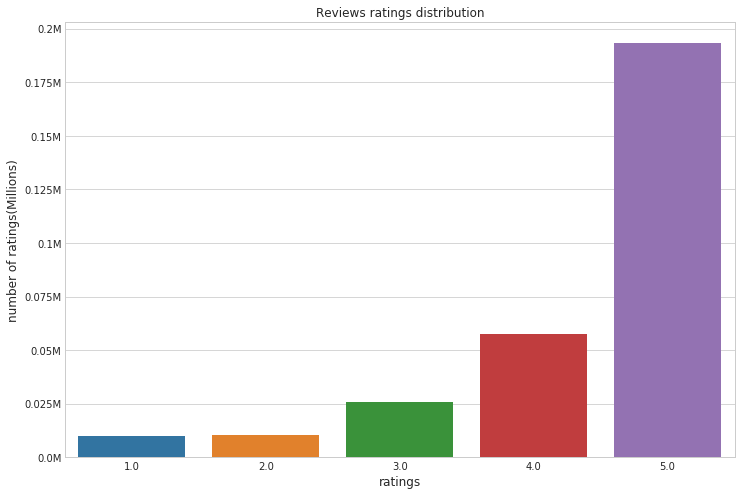

In [29]:
no_of_reviews_per_product = df_.groupby(by = 'asin')['overall'].count().sort_values(ascending = False)

no_of_reviews_per_user = df_.groupby(by = 'reviewerID')['overall'].count().sort_values(ascending = False)

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="overall", data=df_)

ax.set_yticklabels([str(num/10**6) + "M" for num in ax.get_yticks()])

plt.tick_params(labelsize = 10)
plt.title("Reviews ratings distribution", fontsize = 12)
plt.xlabel("ratings", fontsize = 12)
plt.ylabel("number of ratings(Millions)", fontsize = 12)
plt.show()

Let’s see plot the distribution of rating frequency:

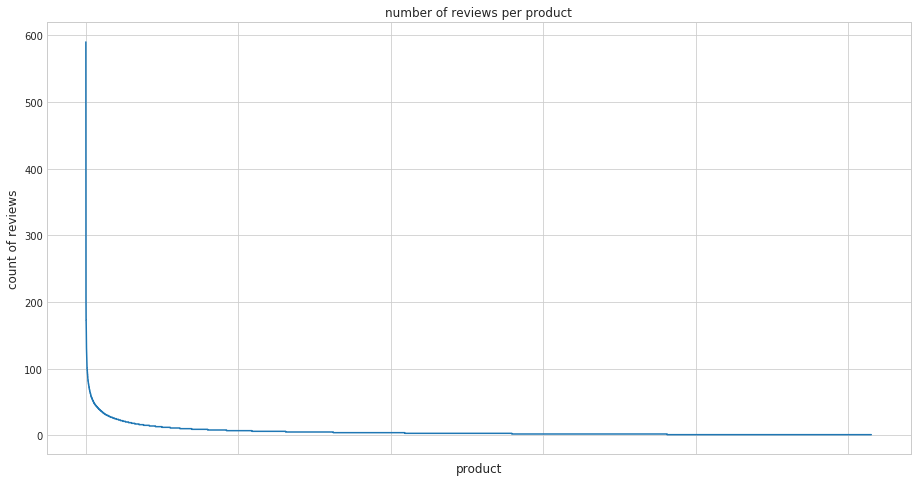

In [30]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("number of reviews per product", fontsize = 12)
plt.xlabel("product", fontsize = 12)
plt.ylabel("count of reviews", fontsize = 12)
plt.plot(no_of_reviews_per_product.values)
plt.tick_params(labelsize = 10)
axes.set_xticklabels([])
plt.show()

It is very skewed.

Rating Frequency is a _long tail_ distribution. Only a small fraction of the items are rated frequently. The vast majority of items are rated rarely.

Ratings data is very sparse and data points are mostly related to a few very popular products and also by highly engaged users. Large amount of items don’t have ratings at all.

These sparse ratings are less predictable for most users and highly sensitive to an individual users who might review very obscure products which makes the pattern very noisy. 

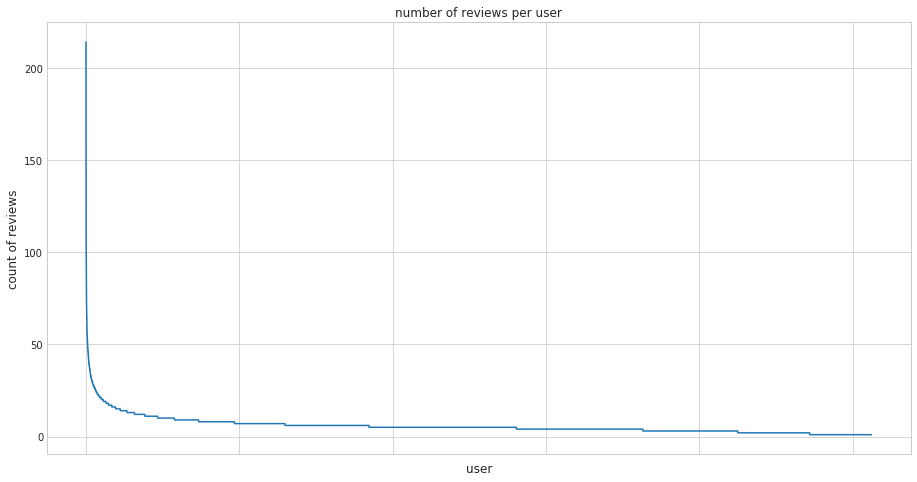

In [31]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("number of reviews per user", fontsize = 12)
plt.xlabel("user", fontsize = 12)
plt.ylabel("count of reviews", fontsize = 12)
plt.plot(no_of_reviews_per_user.values)
plt.tick_params(labelsize = 10)
axes.set_xticklabels([])
plt.show()

In [32]:
quantiles = no_of_reviews_per_user.quantile(np.arange(0,1.01,0.01))

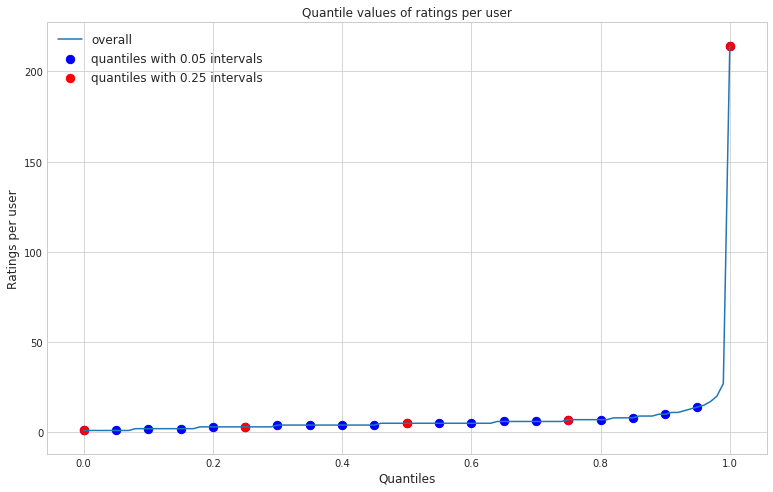

In [33]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of ratings per user", fontsize = 12)
axes.set_xlabel("Quantiles", fontsize = 12)
axes.set_ylabel("Ratings per user", fontsize = 12)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5],  y = quantiles.values[::5],  c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red",  s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 12)
    
axes.tick_params(labelsize = 10)

In [34]:
# print("Number of not null entries in the dataframe:\n", df_[df_['related'].notnull()].count())
# print("Number of null entries in the dataframe:\n", df_[df_['related'].isnull()].count())
# print("Total entries in the dataframe:", len(df_))
print()
df_[df_['related'].notnull()].related.apply(lambda x: x.keys())

0               (also_bought, also_viewed, bought_together)
1               (also_bought, also_viewed, bought_together)
2               (also_bought, also_viewed, bought_together)
3               (also_bought, also_viewed, bought_together)
4               (also_bought, also_viewed, bought_together)
5               (also_bought, also_viewed, bought_together)
6               (also_bought, also_viewed, bought_together)
7               (also_bought, also_viewed, bought_together)
8               (also_bought, also_viewed, bought_together)
9               (also_bought, also_viewed, bought_together)
10              (also_bought, also_viewed, bought_together)
11              (also_bought, also_viewed, bought_together)
12              (also_bought, also_viewed, bought_together)
13              (also_bought, also_viewed, bought_together)
14              (also_bought, also_viewed, bought_together)
15              (also_bought, also_viewed, bought_together)
16              (also_bought, also_viewe

In [35]:
len(df_['related'].notnull())

296852

In [36]:
_df = df_

In [37]:
_df['also_viewed'] = ""
_df['also_bought'] = ""
_df['bought_together'] = ""
_df['buy_after_viewing'] = "" 

start = time.time()
for i, row in _df.iterrows():
    for key, val in row['related'].items():
        _df.at[i, key] = val
print("total time taken to parse 'related' signals into separate columns: {} minutes".format(np.round((time.time() - start)/60,2)))
_df.dtypes

/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

total time taken to parse 'related' signals into separate columns: 0.43 minutes


reviewerID            object
asin                  object
reviewText            object
overall              float64
imUrl                 object
categories            object
related               object
price                float64
also_viewed           object
also_bought           object
bought_together       object
buy_after_viewing     object
dtype: object

In [38]:
print("{:,}".format(len(_df[(_df['also_viewed'].values != '') & (_df['also_bought'].values != '') & (_df['buy_after_viewing'].values != '') & (_df['bought_together'].values != '')][['asin', 'also_viewed', 'also_bought', 'buy_after_viewing', 'bought_together']])))
print()
_df[(_df['also_viewed'].values != '') & (_df['also_bought'].values != '') & (_df['buy_after_viewing'].values != '') & (_df['bought_together'].values != '')][['asin', 'also_viewed', 'also_bought', 'buy_after_viewing', 'bought_together']].head()

1,580



,asin,also_viewed,also_bought,buy_after_viewing,bought_together
25,B001R6W4KA,"[B001DZMITW, B001E8F912, B0077LGDDI, B000J03AT...","[B00BR3E226, B0015KVXW8, B008R2H93Y, B00E0JNMI...","[B0015KVXW8, B001DZMITW, B0077LGDDI, B0037UP9MY]",[B0015KVXW8]
26,B001R6W4KA,"[B001DZMITW, B001E8F912, B0077LGDDI, B000J03AT...","[B00BR3E226, B0015KVXW8, B008R2H93Y, B00E0JNMI...","[B0015KVXW8, B001DZMITW, B0077LGDDI, B0037UP9MY]",[B0015KVXW8]
27,B001R6W4KA,"[B001DZMITW, B001E8F912, B0077LGDDI, B000J03AT...","[B00BR3E226, B0015KVXW8, B008R2H93Y, B00E0JNMI...","[B0015KVXW8, B001DZMITW, B0077LGDDI, B0037UP9MY]",[B0015KVXW8]
28,B001R6W4KA,"[B001DZMITW, B001E8F912, B0077LGDDI, B000J03AT...","[B00BR3E226, B0015KVXW8, B008R2H93Y, B00E0JNMI...","[B0015KVXW8, B001DZMITW, B0077LGDDI, B0037UP9MY]",[B0015KVXW8]
29,B001R6W4KA,"[B001DZMITW, B001E8F912, B0077LGDDI, B000J03AT...","[B00BR3E226, B0015KVXW8, B008R2H93Y, B00E0JNMI...","[B0015KVXW8, B001DZMITW, B0077LGDDI, B0037UP9MY]",[B0015KVXW8]


In [39]:
print("Total number of records in the joint dataset: {}".format(len(_df)))
print()
print("Number of records with non-empty values in the 'also_bought' column: {}".format((_df['also_bought'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'also_bought' column: {}".format((len(_df) - len(_df[_df['also_bought'] != '']))))
print("Total of records in the 'also_bought' column: {}".format((len(_df[_df['also_bought'] == '']) + len(_df[_df['also_bought'] != '']))))
print()
print("Number of records with non-empty values in the 'also_viewed' column: {}".format((_df['also_viewed'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'also_viewed' column: {}".format((len(_df) - len(_df[_df['also_viewed'] != '']))))
print("Total of records in the 'also_viewed' column: {}".format((len(_df[_df['also_viewed'] == '']) + len(_df[_df['also_viewed'] != '']))))
print()
print("Number of records with non-empty values in the 'buy_after_viewing' column: {}".format((_df['buy_after_viewing'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'buy_after_viewing' column: {}".format((len(_df) - len(_df[_df['buy_after_viewing'] != '']))))
print("Total of records in the 'buy_after_viewing' column: {}".format((len(_df[_df['buy_after_viewing'] == '']) + len(_df[_df['buy_after_viewing'] != '']))))
print()
print("Number of records with non-empty values in the 'bought_together' column: {}".format((_df['bought_together'].apply(lambda x: len(x)).values != 0).sum()))
print("Number of records with empty values in the 'bought_together' column: {}".format((len(_df) - len(_df[_df['bought_together'] != '']))))
print("Total of records in the 'bought_together' column: {}".format((len(_df[_df['bought_together'] == '']) + len(_df[_df['bought_together'] != '']))))


Total number of records in the joint dataset: 296852

Number of records with non-empty values in the 'also_bought' column: 291881
Number of records with empty values in the 'also_bought' column: 4971
Total of records in the 'also_bought' column: 296852

Number of records with non-empty values in the 'also_viewed' column: 292817
Number of records with empty values in the 'also_viewed' column: 4035
Total of records in the 'also_viewed' column: 296852

Number of records with non-empty values in the 'buy_after_viewing' column: 4883
Number of records with empty values in the 'buy_after_viewing' column: 291969
Total of records in the 'buy_after_viewing' column: 296852

Number of records with non-empty values in the 'bought_together' column: 288196
Number of records with empty values in the 'bought_together' column: 8656
Total of records in the 'bought_together' column: 296852


In [40]:
_df['buy_t'] = ""
_df['buy_r'] = ""
_df['buy_av'] = ""
_df['buy_ab'] = ""

start = time.time()
for i, row in _df.iterrows():
    if (row['asin'] in row['bought_together']):
        _df.at[i, "buy_t"] = 1
    if (row['asin'] in row['buy_after_viewing']):
        _df.at[i, "buy_r"] = 1
    if (row['asin'] in row['also_bought']):
        _df.at[i, "buy_ab"] = 1
    if (row['asin'] in row['also_viewed']):
        _df.at[i, "buy_av"] = 1
        
print("total time taken to extract buy signals from 'related' column: {} minutes".format(np.round((time.time() - start)/60,2)))

/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/elkayvee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

total time taken to extract buy signals from 'related' column: 0.61 minutes


In [41]:
print("Number of times a reviewed item is in 'bought_together':", (_df.buy_t.values == 1).sum())
print("Number of times a reviewed item is in 'buy_after_viewing':", (_df.buy_r.values == 1).sum())
print("Number of times a reviewed item is in 'also bought':", (_df.buy_ab.values == 1).sum())
print("Number of times a reviewed item is in 'also viewed':", (_df.buy_av.values == 1).sum())

Number of times a reviewed item is in 'bought_together': 0
Number of times a reviewed item is in 'buy_after_viewing': 0
Number of times a reviewed item is in 'also bought': 1
Number of times a reviewed item is in 'also viewed': 0


In [42]:
# _df['also_viewed'].values
max_also_reviewed = max(_df['also_viewed'].apply(lambda x: len(x)))
print(max_also_reviewed)
max_also_bought = max(_df['also_bought'].apply(lambda x: len(x)))
print(max_also_bought)
max_bought_together = max(_df['bought_together'].apply(lambda x: len(x)))
print(max_bought_together)
max_buy_after_viewing = max(_df['buy_after_viewing'].apply(lambda x: len(x)))
print(max_buy_after_viewing)

60
100
4
6


In [43]:
_df.overall.min()

1.0

#### Parameter Tuning 
We split our raw ratings data into two sets A and B.

Shuffle data.

A = 80% of the data, B = 20% of the data.

A is used for _parameter tuning using grid search_, and B is used for _unbiased_ estimation.

Applying **_SVD_** algorithm

Train an _SVD_ algorithm on the whole dataset.

Then predict all the ratings for the pairs (user, item) that are **_not_** in the training set.

Applying different algorithm - **_SVD++_**

Train an _SVD++_ algorithm on the whole dataset.

Then predict all the ratings for the pairs (user, item) that are **not** in the training set.


Train an SVD algorithm on the whole dataset.

Then predict all the ratings for the pairs (user, item) that are **_not_** in the training set. 

Then retrieve the **_top-n_** prediction for each user.



**_Precision@k_**=$ \frac{|{Recommended \; items \; that \; are \; relevant}|}{|{Recommended \; items}| } $


**_Recall@k_** =$ \frac{|{Recommended \; items \; that \; are \; relevant}|}{|{Relevant \; items}|}$


**_relevant_**: **_true_** rating $r_{ui}$ is > a given **_threshold_**. 

**_recommended_**: **_estimated_** rating $\hat{r}_{ui}$ is > the **_threshold_**, and if it is among the **_k_** highest estimated ratings.


In [44]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

data = Dataset.load_from_df(fd_filtered_[fd_filtered_.year.values >= 2012][['reviewerID', 'asin', 'overall']], reader)

kf = KFold(n_splits=5)
algo = SVD()

i = 1
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print("Fold: {}\n".format(i))
    print("\tPrecision averaged over all users:{}".format(np.round((sum(prec for prec in precisions.values()) / len(precisions)),2)))
    print("\tRecall averaged over all users:{}".format(np.round(sum(rec for rec in recalls.values()) / len(recalls),2)))
    i += 1

Fold: 1

	Precision averaged over all users:0.88
	Recall averaged over all users:0.92
Fold: 2

	Precision averaged over all users:0.88
	Recall averaged over all users:0.92
Fold: 3

	Precision averaged over all users:0.88
	Recall averaged over all users:0.92
Fold: 4

	Precision averaged over all users:0.88
	Recall averaged over all users:0.92
Fold: 5

	Precision averaged over all users:0.88
	Recall averaged over all users:0.92


In [45]:
# First, train the algorithm to compute the similarities between items
start = time.time()
data = Dataset.load_from_df(fd_filtered_[fd_filtered_.year.values >= 2012][['reviewerID', 'asin', 'overall']], reader)
trainset = data.build_full_trainset()

sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)

algo.fit(trainset)
print("time taken to similarity calculations:", np.round(time.time() - start,2), "seconds.")


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
time taken to similarity calculations: 228.09 seconds.


In [58]:
# First, train the algortihm to compute the similarities between items
start = time.time()

iid_values = fd_filtered_[fd_filtered_.year.values >= 2012]['asin'].values

neighbors = {}

for i in iid_values:
    item_raw_id = i
    
    item_inner_id = algo.trainset.to_inner_iid(item_raw_id)
    
    item_neighbors = algo.get_neighbors(item_inner_id, k=100)
    
    # Convert inner ids of the neighbors into names.
    item_neighbors = (algo.trainset.to_raw_iid(inner_id)
                           for inner_id in item_neighbors)

    neighbors[i] = list(item_neighbors)

with open('neighbors.txt', 'w') as file:
     file.write(json.dumps(neighbors))


B004JIL6G6
B003JBYYNG
B0049DJPUU
B004K1EZD8
B001R6W4KA
B002I4OTA8
B001LF3T6K
B004LCXH3K
B00143XOGO
B006GDLDSI
B0006PKZBI
B0007QO4FY
B001KXML0I
B0015GMFNS
B001W95O04
B000F5FK2S
B004VMT90A
B001W2WKS0
B000NSW0LQ
B001GZXYFG
B0036QSNJA
B004VCT14Y
B0002YDQBY
B001PIJE6W
B00514N9YY
B002Q4KF5S
B0038ZL5MQ
B003EIK136
B000FULOBE
B0038ZN4KC
B004ORWVQG
B001HAO6PC
B001GSKCAI
B00540990S
B00388IS1E
B003TSCY0O
B004P5O3UE
B00555TX76
B0038LJS9C
B00146LV5C
B001T88NVA
B003JQT4Y0
B0036B560Y
B0045H4EPG
B000FYVNLQ
B0048EK0AE
B005E7A216
B0038OMQ8Y
B004LL0VV2
B004TVGC08
B003U2SAZC
B003F1FWBS
B003F7WLAM
B002MUANJE
1603801014
B004OT2S8K
B002SXMH3K
B003M5ZB0O
B000SKLREA
B0002H7AIG
B002SXMH3A
B0015KVW56
B0044UHAS2
B004P98QM6
B00004T71J
B001TNVYVQ
B004VHURLK
B004N9B0MG
B0007Y4DLG
B00000J4XU
B003WR48VA
B004N9B0MG
B002MY473I
B001449P7A
B003EGQ5JC
B004TS8HF4
B004UUKMUE
B0015399MG
B004P95ABG
8499000606
B004478GG0
B000FY03E4
B0055RTAY0
B0009JCTJM
B000J03ATO
B004P1IPU2
B0006N8WFQ
B000A12YBW
B00005BAHT
B004EK5A4I
B000H6FIW2

B004UL553W
B003V1MN3C
B0017QLSSE
B0042RU070
B004RAHBCY
B003AU5YPS
B000VO3HFK
B00000K3BR
B00385MZW0
B00004WHN9
B000GYWXZ0
B001FWCO7O
B005E7A216
B00342RO4Q
B005QOW2GK
B000SQTJJO
B004C7S70W
B002L3TS0C
B004RSGBOA
B00DPK11ZA
B0042T8GR4
B000VRE5G2
B004C4YVGO
B0042L64IU
B00350EULW
B0000E6I1F
B005TYALDS
B005TYDODM
B0042ESH7I
B006B6RWU8
B0029WLJ8O
B004E9TU22
B000038A8G
0963679600
B004E9TU22
B001U5N786
B004Z6HD82
B003BDKGPW
B000BIX382
B0042ESGRO
B00083DD4O
B000MPLZW0
B00004WKVI
B004UU83IC
B004PXSJTC
B002L6I9ZY
B001QIL5ZY
B002ACOPQ6
B000HKLBE2
B001JQY6K4
B00ALSRRYS
B0042ESH8W
B004S6E4TU
B0042ESHA0
B004XZFM10
B00383GDXE
B005TYDSKQ
B004WH8RFW
B005TYDZQS
B00439HF2U
B003V5XV3Y
B005UFAG1S
B00112CHD4
B003XOVNB0
B005G4GM1Q
B004QF0L4U
B004CLZUR6
B000LS1CKI
B001GE1VWA
B0009PAN1C
B0058FJL66
B000MIOVJQ
B002UHJT8U
B00270DWOW
B000BIZ86W
8499000606
B0000658L4
B005066VGQ
B000F9ISX2
B004CNIXG4
B002CJMBF4
B0045R7U9S
B004U5FRQI
B002NE792I
B001THK41I
B00153KUGU
B0006N8YU4
B004FRMSOK
B002YQU0T4
B0036FQLPO
B001D3YCIO

B0002HZHUY
B0010SGZEG
B001BHK6FU
B0014K5ZUA
B0012BW0WW
B003CRCQLO
B0062JXHVM
B004GTMB0I
B005EM9AGE
B000GL1HV4
B004P971L8
B004ORV2WK
B000BGT6CG
B00000ISFO
B004P971KE
B004478GWE
B00388IS1E
B004U52VBW
B003M73CH6
B0019RH5P6
B000CBSNKQ
B00008W75M
B000IJGULG
B00004WKVI
B000JVJ8KS
B000UEL226
B000GUEXBG
B0054YG8LC
B001IDM7VI
B00004U3F1
B0044UHJ4W
B00476O4N2
B002YNS0EE
B00499CVD2
B004NRN5F8
B004P5OGIS
B001LU6RL4
B002S4U8M6
B000OZV550
B004NQZX7W
B002EXKF4C
B002GP5XL8
B004XONSLC
B004WNAB3W
B0021ZQP60
B003W5TQU0
B004U18K7U
B00000IZQP
B005EFZY5W
B002GEZA3K
B004WNJC0U
B0046UWHZQ
B002ROKTI0
B000BVMFLK
B0050QQUWQ
B004P2CQM4
B004XJBW5G
B000AXMJP6
B004OYOFZE
B004ORWVQG
B004U5FTBG
B003J6JDH8
B004P4TNWI
B001285LBW
B003ZKJNVY
B004OWR0N0
B004FPZ9PM
B0014WO96Y
B0048WAO4I
B0061J30VU
B0038BHZW4
B004SGSSZQ
B000BX1ZSM
B002MQ9VN2
B003286BNW
0786955570
B001AJTTLQ
B0063NLRR8
B003TZU7LK
B003CT4X3Q
B001HNL1SY
B0036UR1IA
B002Y8MOJG
B001AGZXE6
B004SP3YAQ
B004GHNFKK
B004GHO30Q
B004SGS3B0
B004ORWXFA
B0015KA6DU
B002YIRKBS

B005R46LWK
B000GL1BHO
B003CRI1OU
B001P06GX4
B004OH2AW6
B000W3XEQM
B0047XWCIO
B001MJU7LK
B00009YOQK
B00009YOQK
B005AVXWQS
B0057576XC
B003IKN4P2
B000H70S1M
B004I8V720
B000KMHBFA
B0047WW59Q
B002DHG7L4
B000062SRJ
B002PSREAO
B0057PEB2G
B000BNENIG
B004USRAWO
B000OCXOGG
B004USRAWO
B00112CHD4
B002PEBDE6
B004ZX141C
B003XPWNA4
B003D7F4YY
B000NSW0LQ
B004SL1HVI
B003D7F4YY
B002ERB4O8
B000ALCK8E
B003XPWNA4
B004QF0L4K
B000ALCK8E
B00009XNSU
B0009Z3JEK
B000MDOYZW
B003FLMZMW
B002YVJR7A
B0060GDS8E
B000MF20MO
B0006N8X3M
B00420F374
B0043ANEEW
B004FPBBSG
B000K6MT08
B003DGK1H0
B005UNN9LY
B000TLW3NC
B000H6H81Q
B000EUKRY0
B0044KN82Y
B002YVJR7A
B0016H7N42
B001JLD4K2
B002PD8R6Y
B002YQU0GW
B00068Q7LC
B000KWJSKG
B005CK8T3S
B00068Q7LC
B0001VJWFW
B004Y4C25E
B004IF50SU
B00BRGEKZ2
B002SE5ZE2
B0034L1PDI
B0024FA8IS
B0050K074E
B0006JNS2M
B004U5RD1A
B0057M086C
B0016C64IS
B00000IVZJ
B000BNEN90
B002M78DSK
B004V564PA
B003XNTSFO
B001SN8GCW
B004K9CHR6
B004P93ZYK
B000FBX55Q
B002YP48CU
B004LOKRDG
B003UT79SO
B0010E6JLO
B001NLOPCO

B0007ODH90
B0048JGWYW
B0017U24H4
B003XOXLP6
B0048WQHGW
B004NCEL4M
B004ORQ4JG
B000H6FJI0
B0019RV7GY
B004WMSH4S
B0007QO42W
B001IABZKU
B000MWWXGK
B000H6FDPO
B0040Z1ERO
B001ALLMX2
B0007OF1QC
B000W3TD44
B003XWZZJI
B0041D8I2E
B002Q4U71K
B000BOBGW6
B000MVTUBM
B005E7A216
B004IWRFUO
B004WH8RFW
B0001NE4VC
B003KY8PR8
B00604WA8A
B00008W75M
B0038APD2E
B001EHM48Y
B000ELSZT8
B003B6LCIY
B000BK7JTO
B000P178HW
B0058NUAKY
B004ETB4TY
B0057S9PKG
B000LT1CMK
B005OTX7LG
B002ZCYCBO
B000YEPPFM
B001COHSPS
B004S6EBIO
B0031ES9LE
B000W9KCMU
B000227NEC
B000BXFMUY
B004ETB4TY
B004P940US
B002VECERA
B00001QHVP
B004Z7H07K
B001QVI9CI
B004TVGBP4
B001AQDA50
B003V7BR5Q
B003AN72DW
B004PS8LEA
B0035YAG3Y
B004RSGBOA
B004C7S70W
B00F4WMAI4
B001E1MU16
B000LDVU28
B004PS5B34
B004PBER7C
B002ECUUZM
B0079VHSD0
B004S6DXKG
B0013D53CS
B003ZWLXVA
B004TVGBZE
B000WPJQT4
B000BI2QP8
B003NNVCCG
B004ZHCNZE
B002BG3I7I
B0041O8P08
B004RAHBTW
B004LOKRDG
B005OLZ1V8
B004WH8RFW
B004TGPQDW
B004XPLOZS
B0000CE099
158994030X
B005FAP9X8
B003B9EFM6
B000CBWWO4

B00132HXEK
B00186FCX0
B0006NGVPY
B004I5ABCU
B0043WCGZ8
B002MUANJO
B0049B3D9G
B004P972FS
B005GTJ0AG
B0049RMMVU
B000F3V2R2
B0008JIL90
B004NQY0QM
B000NPNVJ4
B001RPWM7Q
B00062J99K
B002FU5NQ4
B002ZKXR9Y
B000IBPD76
B004EHYGNC
B001EC7S4O
B003UWQVJ4
B0064AGK2M
B00021Z2FU
B00134PM7I
B0050R0XEG
B004SGOSI2
B003551WHC
B004CT3HKU
B002ROKTI0
B004SGOSI2
B004L63YG6
B0030CHCQ0
B0000205XH
B000LE2BAW
B0009XBY30
B004P98R6Q
B003AN6H42
B00DPK11ZA
B00004Y5PQ
B0052D31FQ
B001J1KJBO
B004BKJ87G
B0007LD3OM
B004I9VTKE
0976914417
B004Y8LP2G
B000GBMHB8
B002YGSRIA
B001W2WM06
B001DTEFJE
B004Y3U7PM
B001U5R200
B004NHSKL2
B004NDB41Y
B005CK8T3S
B005E7A202
B004Z7H07K
B001DTRD4S
B0012K3H52
B002SNIK4U
B004FEP0YI
B004OS4HF8
B003DTMQAW
B00021PUE8
B0000658L4
B005T3R9FM
B00439HF0M
B0019L9FFU
B003OTLIV4
B004P971L8
B00009YEGL
B001BDC4Y0
B00350K066
B00000J58X
B0038APDDS
B0050PJIPS
B003TJALF8
B004VV89Q6
B00531DHX8
B003AHG3FG
B004P98QX0
B004IAOU8Q
B004SGVFBU
B002E9WZLC
B00388H3G0
B004LYAL96
B0032W1M8M
B00000IRRY
B004SS5YDS
B004239XUY

B005PO8PW6
B00005NQE8
B00064S9RQ
B006HZX1P8
B005LZZSAG
B000VO3GPG
B0042ES5BG
B002SXMH3K
B000I3ICZE
B002RL7VPW
B003WTWT6E
B001QVI9CI
B000GKD006
B000VO1CIE
B00094DMMU
B004UEO7XI
B00DPK10O2
B000AS206O
B0042RU070
B004IWRFZ4
B001Q4FGXK
B002AT139Q
B000VIO6XS
B0045UBG86
B0055DXP40
B0043WI70Q
B000I5HOPG
B001SOZDFO
B001UO0EPQ
B001MKRQBS
B000O7IX4Y
B0018IJ14E
B000088UPW
B0032W1M8M
B004HHJNQ4
B0019I3A54
B0055WPZDU
B000068CKY
B000O1T52O
B004C03S76
B003WMC6U0
B00362MLOM
B004QJLA9Q
B002FKJKDG
B000BXJSY0
B005JZOCYG
B005E7A202
B002R9G1Z0
B00AAJ6CO4
B005JZIBUC
B005HN4HRM
B0057HLRJE
B000062SRJ
B0024UXJ3E
B004OWNS1I
B001RPWM7Q
B0009HXWCM
B00005UM9P
B000EF5IN0
B003E1UTTY
B0036DDEW4
B006RQ8TVS
B00385QUTO
B004I8V716
B004MWN1AS
B004P7QDE6
B000M5J7W0
B005EJIYG4
B001RNC0VG
B001PAKU0O
B00146K0KE
B000BN8XLY
B002M03F3U
B003MTBJS8
B0047U0XLK
B000KIJCYC
B0015KOOHO
B000E74HR6
B003XT827I
0786955570
B0001VJWY8
B000UI8CQG
B002Z46H2E
B00365OLU6
B00069L7ZC
B000NZJZLC
B000BVMAJ2
B003TJALF8
B00253T7R2
B005717VUY
B001T1BQUC

B005UWYK22
B003R39DQO
B004U53AA8
B0002D1FEA
B00421AGGG
B005A124U8
B004T1R75W
B00123UFAO
B004MYH0BC
B004FPZ9PM
B000ML91WK
B002I9Z75E
B0042ADECK
B00385MZVG
B00000DMER
B000NSW0LQ
B000FA6B2Q
B005Q9QVXA
B0002KPGD4
B0030G7J9G
B0043E2XAO
1223062341
B000BBXBPY
B002I9Z6SC
B005717VUY
1932359842
B005VPRFIO
B004KZCF0O
B003KR9R04
B006RQ8TVI
B000NLMK2M
B002PAL1I8
B006BA736M
B004IG8B94
B005MEDJ2K
B005FCNYVA
B00005UFC1
B004MYH0C6
B005D5U5LQ
B00004WKSR
B004P5O3WM
B000NO9GT4
B00008O0X5
B004OH3USY
B0015KVW56
B0017L3SPU
B0036RMAQQ
B001L123JS
B002YQSEY2
B005QBQBXS
B0060Y240O
B003XDUOAW
B0028K2P76
B004S5Y8AG
B0038BAHGK
1223069192
B003EIK136
B005N548KK
B0040GK7MG
B004U52VPS
B0015IPGD2
B003B98432
B0030FVG96
B003A5RTHO
B005UNPB4W
B000FJ4AD4
B0045OV9IO
B0057UDE0Q
B000F8T026
B001TLRV9W
B0060S315W
B004C7S748
B004TA8WA2
B000VC2TPQ
0979959330
B004OA7ZH8
B000MEB5LM
B000KO7QK8
B005KIQDYE
B0038LNPU0
B005GSFU4M
B0000E2DJD
B003FZAAIE
B00695JBRI
B000YIQIMM
B001L7VY1U
B0001U2CFU
B001TR0742
B004M2K9B2
B0050P1OZK
B004ORT3OY

B000E9DPVI
B0038APDDS
B001FPQ5Y4
B000EDQGLK
B003YDO65K
B005E6UTP6
B00385QUTO
B00153BFA0
B000GUEXBG
B003YJJH62
B004PBJPN8
B0014BP6OY
B001607Q5U
B001DN4QF8
B004S6DX74
B003AQBWS0
B004A8ZRBA
B002R3DL5O
B001W03MH0
B0043E8N6M
B0050OTO2G
B0045UBG6I
B002SPQO4G
B003V8A4I6
B0045WRNP4
B002O07JLW
B000G334Z4
B004XPIQJ0
B004TSIA0G
B005OHLAG2
B0057QY0U8
B003WIPSL8
B0042ES5BG
B004RAHBTW
B00005UM9P
B002IF7NZU
B0010E4OWU
B0033BM3K8
B00009ILYC
B004Z1JUJ2
B00009RGTW
B000BNEN90
B0027FF2NG
B000ETRENI
B003CGWHRS
B0032JTJXA
B0040F2OBE
B00009ILZF
B0042RU07U
B001NINZ0K
B004MWBGOG
B004UFHE50
B0036WSLX2
B0016JC2JG
B001AQS212
B0035CCDPU
B0071BYCAA
B004I7232Y
B005KISGI0
B004SN67T8
B006889QXA
B004SMGDF2
B003UBOK0M
B001BAMOQG
B004HFIQVY
B002SX7ELK
B001D0C70C
B004WH8RFW
B00001WRJ5
B003B1ZHJE
B000C1A4L2
B005G3WD8S
B0002CEXS6
B002YI6FC8
B001SN8G86
B00009YEGL
B001BW4F8E
B004I8V6Z8
B0044KN84M
B000P43V6G
B00023DENA
B002QXRGGU
B0037UUZAK
B004S6DVMQ
B00134PLT2
B005ANENAU
B004C7QNMG
B0043E2XAO
B003H9MUL8
B0002AHQWS
B003YKPJC2

B000VZU7CK
B00063FE66
B004UU7AFE
B004OGBNJ8
B006RQ8ULC
B000LBW38K
B000IBESXG
B000UPETFM
B00009ENDT
B00004TQMQ
B006RQ8ULC
B004PHTXW0
B0006HIZRW
B003B98X2E
B00007L12O
B000F4ELZ6
B003H2IN3Y
B004S6BXH6
B004ORRUG2
B005O1BLV2
B004IRB8CU
B000MRVCZS
B0006NM1J4
B004ORWXPA
B005VPREJ4
B0007871KM
B00DPK11ZA
B002AMVYQ0
B0050QJTMO
B004PR49F6
B002HZ1FWI
B004PHRY4E
B0038AT564
B004S5WIJE
B001O2S6MM
B004VKTP4W
B00383PNBW
B0045AFXFS
B003PNW7UK
B0011MTFUM
B001W3HY8K
B0037UT3E4
B001F2G8T4
B0038BBHMS
B00005LOXV
B001GZTCNO
B003EE9IJI
B000M5J7W0
B000G3LR9Y
B004R0HME6
B002SZFK2S
B0039UTUXQ
B003U2SAZC
B005VN0XRG
B004R1ZUNA
B0018OXZF4
B000X66KRS
B004667TG2
B001DIN2EO
B003WZHG5M
B005VQ77PY
B000SQKDSA
B005VQ77AE
B00572GD9S
B005QHS4AA
B0014QBZ12
B005VQ76U0
B005E91LJ6
B0006HCA82
B00572GD9S
B000N1NDHI
B0058RD8YK
B001E0NDQ8
B00005BLMC
B003WFFFRI
B005IFW3P2
B000BDG7QC
B004KZ741E
B003WFKOSS
B00004TDTQ
B001R1RRC0
B000NSW0LQ
B001HZBRO0
B00392NSQ4
B004U5FRQI
B000NBM3QK
B0037XA2IW
B0006JNS3Q
B004Z1JSN0
B001BWY5C0
1603801294

B0057KTMO8
B00004SU7V
B0008ELWYG
B004GJXJLS
B001R6W4KA
B004M17H68
B00419T56Q
B0042HOUA8
B00012TL34
B001OH9EDW
B005I0K4HQ
B00006IFJ4
B004ORV2WK
B000FGCY8K
B001KBYU0E
B001W0B7N6
B00004YTPV
B0026YYCYS
B000CD8CQO
B0009K3116
B002TI6XAM
B000VB876C
B0031KVY1K
B0050JQVPY
B004OS8FWY
B0039S7NO6
B002TX6SA2
B003C9G6H2
B004GR9M34
B0055CAF6M
B001U0LJGS
B006BA736M
B003PGRGGW
B004R7S8WY
B002QNM8NQ
B005VPXWRC
B00106CGP0
B000LY9ME0
B00261JTB2
B006D0GO6U
B004NWHG9O
B004Z7H14M
B002VD0TEQ
B004C3LNWK
B001GFITE2
B004SL1H36
B003FLMWS4
B004U5RD1A
B000PE6BKO
B000IE6ZW0
B004IYJ3H0
B004OS8J98
B004UJF0DE
B004Z1JRO0
B004V4Z3XU
B004PHU8XI
B004M17H6I
B0035RRPU8
B003IPVZRQ
B0026J7EIO
B000IMT3PS
B0034IQB76
B0015KOOHO
B00428LIY8
B00501LMGU
B005175V6K
B001P06GZM
B005ZI6ZH4
B004J30ZDQ
B002LDXZYC
B004R7RB86
B0008G2VBM
B005DLZ2AO
1604189681
B004M17H68
B00468HMDA
B001CD47DU
B002SKTQTQ
B00376VWXS
B002SNA5HK
B0007Y4DLG
B004S5AEYK
B00030EP4E
B00000IWHG
B003OPTVSA
B001B1LVZA
B0050EQRJ4
B0002F7KTW
B002SDSTLY
B000OAA74U
B0038B9GG2

B000NP355Y
B003H7SIXO
B002QE189A
B00021HB9U
B000062SQA
B001PJZIK2
B002IUNLLK
B004M26JHA
B003MPJGGY
B002YI6FC8
B003H7T7BG
B00093DHIK
B006X9KT0S
B003YKAZYO
B0002YDQBY
B006YKE6D2
B0057CP1L4
B0036RIPII
B0014E7DIS
B003F82G24
B0026J7EIO
B000C8IMQ4
B006CC0HR6
B000M6B42K
B004P90PDY
B0053OY0JA
B002B8VL3E
B001US69QK
B000VHA3Q8
B004M17DBC
B004OGBNJ8
B006ODSI42
B0002MHMFM
B002O6NQUY
B000G0F3EM
B005XTLP8E
B006ODSI42
B0044A8FXQ
B0061PTTX2
B00007L12O
B003P8QIE6
B0042WOASA
B00392NSI2
B0031ES8P6
B00134O7RE
B0037UT3E4
B00004U1RA
B004YTYUGI
B004PBN2KU
B001I8BZZC
B0035E196C
1616611715
B001UTEDNA
B004I64198
B0043WCH3Y
B003LS5X0U
B000KMHBFA
B004QPRG5C
B002WB1GGW
B005GWID1A
B0041OHX3I
B0013Z9B7O
B006DIEA7M
B002VECEP2
B005XTLG8S
B003XGB80E
B005SG8UNA
B001A6BVMO
B004TLICW4
B002861OR2
1589942108
B000KMHBFA
B001RNBIIM
B004YDFG12
B004VEPQ1E
B00BGYR0LG
B006DIFJQ8
B0037UUZQY
B001DA8YU4
B0064NWU9G
B004XOILTG
B002NPBT50
B004ARTY2Y
B003XXN9K4
B00005J36F
B001H07J0Q
B005GHOE1S
B0010WC13G
B0062DMB4M
B005VPRF2K
B00000J2B5

B00006408Q
B00169FWF2
B0035EQDW2
B00068Q7LC
B005KISGI0
B0077D0FIK
B00655APXG
B006K11RSW
B003COZJUM
B00383GDXE
B004HL0A12
158994223X
B000M8G2FW
B001TAGANG
B0009B0M4E
B0053WMSTG
B004A8ZRBA
B005KIQDYE
B001EHEH9S
B000LR9BHU
B004IA5YZO
B0035YAG3Y
B000ICKV86
B000ETA11A
B0007Y4DLG
B00BWIRZY8
B00029R6GA
B004TN7L24
B003Z9FMSI
B006CD2FAM
B0001WGISK
B0006M6VV4
B001QVAJIK
B006CD24T4
B003EE29RG
B0052PXPU0
B00421AGOI
B006CD27NC
B0060Y271K
B004TRXB1A
B004S6DWDY
B003VIVVEC
B00004TXLQ
B006CD28WM
B003CJJE4Y
B004I5AU30
B001UGX0NM
B0060Y240O
B006CD29MG
B0042ESHDM
B000FJH0C2
B006CD2ACU
B004YCUKVE
B000MQAP52
B001W32FHU
B004CVSVW2
B004U5RD1A
B000038A89
B006CC0HR6
B004PBOGRS
B0039S7NO6
B003EUAX0K
B0037UT3E4
B000087L1K
B004DJ51WQ
B0007P5KHG
B0007ODGTQ
B000OF0EY8
B00486ZVXS
B003F7YNGW
B0042SSUJY
B000BL9Z18
B0016OPFYA
B004SGRW6C
B00009YOTF
B001IEZ1EW
B003NNVDUM
B000256TD0
B0031ES9IC
B0013LRBH0
B00333GL8G
B005KT2JMS
B000W3WGFC
B001TIXOEQ
B004OY9EGO
B0060Y271K
B0060GDR62
B0062DB7K6
B004UIATJA
B006CD4118
B004QJVBHW

B0014P2ZXU
B004J110XM
B002Z3PIZC
B0024IQWMQ
B00000IV8D
B003A7ML6Q
B005FUKQ7M
B004A8ZRBA
B004DKPR06
B006BLGBXC
B003EEMIU4
B004AO83GK
B001J8NGCQ
B000RRH2HU
B004USRAWO
B0016282U6
B004JLNUZI
B0038BE94Q
B006CD31RI
B0001LATN6
B006CDBK30
B004FEMZQE
B0066ESHUY
B000N1RVJO
B001JK4MRM
B004CRYE2C
B00006667N
B000LSZVKA
B004SN66XA
B0031QHQAW
B003KYTT7S
B0009JDCKW
B000YUTVRE
B00006JZCS
B0040F0NPS
B004617DEU
B005N9N4MO
B00C4VFOSQ
B000WOOGX6
B0002VJYSQ
B00000DMFD
B0045M0R66
B003HC92N4
B004B9J5BQ
B00134V4L6
B0042U3J9I
B0015KU14O
B004RKT8U2
B006CC0BT0
B0006HJSJQ
B001F65CXI
B004IGSBRG
B004FEL5SI
B004FPHIEW
B000A0IBV0
B004KUCMXY
B004KGTM90
B002MGXP5M
B004WMSH4S
B005FUKPPK
B004FPHIDI
B004OA7ZHS
B004SKXUVE
B004RQ64Q2
B003N9LMFW
B000MU6GPG
B003GK798M
B00024QU8K
B00164YTC4
B006BLGBXC
B00F4WMAI4
B000JCMJCQ
B00005BZM6
B0028WB8AE
B0036IMS7Q
B000P67IKE
B000NDGQK2
B00085EWWE
B003S9VKCW
B00009KWV5
B0002AUWKG
B005EVC1B6
B0014P2ZXU
B001RNJ8WK
B003YALJJE
B000LY6N6K
B0006I5GT6
B0000Z4WZ4
B00785LNHE
B00339QX6A
B0062JXHVM

B0043WG6IG
B004GW3CAI
B000GYUZ1O
B002WB7WOW
B006CC0TQ0
B005NJFSZK
B001W30E14
B00004WKVL
B004FG0ZWI
B004WLI4S8
B0043VRO06
B004O9WG5U
B000FJ4AD4
B00405CZIG
B0006GKAEY
B00004SDBL
B00128HKSE
B006CDBK30
B001T8OFQM
B00001QEB0
B0032VJ5W8
B0031ES8OW
B004RQIYF6
B00005U8TE
B001ESGV28
B00427XBLW
B0072A4KRA
B00009XNSS
B000EHJ8XE
B005XTLD40
B006S9MUPU
B004KHYXPC
B0056LAK0I
B00078ZHIU
B0027GLJEQ
B000GL1GSI
B000IUYPZI
B001FLTMY8
B001H00156
B0044DJVLS
B005HIOVOG
B005JZHUAE
B006CD4118
B003TZU7LK
B0014D8D4M
B0025MMLYO
B000GBA60W
B004FENVV2
B00000IWIK
B002WBA1Z4
B0030HBVG2
B00009KX2L
B000GHDR1G
B006CC18V0
B003AQGHD0
B001HZJT5E
B00001QEAW
B001UHMTZQ
B006S8EWA2
B006BLH4XI
B004SGS3B0
B000JY526Y
B004ORV2WK
B00009IMAN
B00008J1AY
B00385X51U
B002ATIP92
B00140VZ90
B006BLH4XI
B0006GKD46
B004UC4N1G
B004AF3ZHQ
B006S8EWA2
B000087LI0
B004SGLDM6
B0045OV8YE
B0033C448G
B004PBHCC4
B004S6DVMQ
B004ORWVMA
B000GX40PW
B006ONCYRE
B0019RH5P6
B004SQ0DZE
B00332WHM6
B0036FFPCY
B0001MIPXQ
B00004T2XL
B000ZKRDY6
B0015399MG
B004S6DV2G

B000VXDJGS
B004K1EZ6U
B001CQPRMC
B004MU3SVM
B0046R7F1K
B006CC0BT0
B0053OY0JA
B0038BBHMS
B0018Z7XO2
B0040WLBQ6
B000O5HGI0
B001418JJS
B004SN4OY8
B000YUTVRE
B0010SGZEG
B001KW063I
B003TZ25ZG
B0001NE93K
B000K27MPO
B004MWN0G8
B000NRRXRI
B007GE6UBG
B004GXHOGK
B000ZDME7Y
B004MOR7DS
B0001NKSCQ
B000O7IX4Y
B00354PQX4
B0060GDSGQ
B00361FUG4
B002RL7VNO
B0014JPJES
B0042RU070
B00318BY58
B0051MMFRS
B0070A9OUA
B0018SJY64
B003YBIEHS
B0007Y4DLG
B002ZF13MM
B006YWI5QY
B00005BZKD
B0045H0L1W
B000PWWZNS
B005T3R9FM
B003HBW27I
B0062NLZO4
B0047MMH6C
B001PJXGLA
B0034SAJCE
B0006N8YU4
B0058LT818
B00091QWIE
B0041TABOG
B000ID31Z0
B003KYTXXI
B0060GDS8E
B0006IRTU0
B004PW1XRI
B000M8H8Y6
B000NRRXS2
B003TRECZA
B0000683A4
B000W3TD4Y
B001RV58QW
B002XFE09C
B002QX2W3M
B004ORYVJG
B001P9OGRS
B00000J0B7
B000F4ELTW
B000SONEQA
B0012NXMFE
B004I8V716
B001QT274Q
B005C3F3SY
B0014YPEI4
B000N1VP3C
B005OHLAG2
B000F3O1IY
B006ZBPFBC
B006CC0HR6
B000MCHFZ4
B0076TRVGO
B006CC0HR6
B000YETBHU
B0045WX9YS
B0044KN81K
B004HFPKSQ
B003XKMFG6
B00200JWQQ

B002SW19GC
B0032JTJJE
B000B6MLFA
B004GJXJLS
B0036ZDT18
B003SMA6CO
B004JXX75O
B003WFQD56
B001122JJ6
B003IYYJ9I
B003GIS8SO
B006CBZW90
B000NZPPFM
B000OVI6RE
B00351JK98
B001HSYPKK
B0042ESGDI
B006BMA0LK
B004AGMTNG
B0009JCTTW
B00522WWFW
B000IZ9N78
B0043G64TI
B0060Y282I
B001EH1ZVG
B004S6A1QK
B000BB56B6
B005UYIX5K
B004LL0VV2
B000W3TD4E
B004083ELK
B003D7F4YY
B002EZZ6QW
B005OK2YD2
B0006OHNCI
B0009XBY30
B007GE6VMO
B002PAQIPE
B0010YWQD4
B006IJL0CE
B0038AI0PQ
B004IB03UO
B00030EPGM
B006IJLL82
B004QM91JE
B00009KWV6
B000VO3HC8
B000F49UY8
B0047HR1CM
B001U5SMOU
B00705JGX0
B00200JX2O
B001U5P978
B000ETRENI
B000BZ6TZE
B004P972UI
B0074BVT58
B0017OFRCY
B0017VPKY2
B00008X342
B00000ISC5
B000GPSUEW
B001AQDA50
B000GKE2N0
B005VPRG3S
B0039LXKHW
B004P9591C
B00000IV3V
B006BMM3IS
B004L036K6
B004VT0KC4
B00428LIXO
B004ROGN5G
B000X764IW
1589947207
B004ALKLR2
B000SONEQA
B0050D1R3Q
B000X75B90
B000OVJUVK
B004SMX7YC
B000EWUVVM
B006CD4118
B005KP1E14
B002C3R182
B004Q65BRQ
B004ZK6LXG
B001W0B7N6
B002YUI5RE
B003AH6MXY
B000BOCPYO

B001RQ45JS
B000IBPD76
B001LFCIKS
B001SC6IU0
B002YIOA98
B003B7Q5YY
B00000K3SP
B004PBLL0S
B001MUDKL8
B000T2YKIM
B007L4964E
B000CIQ4E6
B0032JTJUI
B001JQY6K4
B003WE34HC
B000V0H908
B000BNLVA4
B000S34PO6
B0002AUWKG
B0037Z8DEK
B0000BX8MA
B006DR6P9O
B0002HNLWK
B004RILCR6
B004T5ZV6U
B001NVAEM4
B001S49XH8
B003E0MJCA
1936112191
B00270YD22
B00166BS4E
B003H9MSPG
B003YJER8U
B005MX72O2
B001UZHASE
B003COZK2E
B0031P91LK
1936112159
B00486ZVC4
B004HBWKII
B003NTELC8
B000VOQ3W4
B004C03S5I
B00651A7WE
B0044784I0
B006XKQHD0
B000RZOGMQ
B0000658L4
B001KW063S
B000MOL27O
B000FINQ08
B003774W6Q
B0044A9X28
B006RQ8TGS
B003WFOECA
B004FPHIDI
B007BSYAVY
B004H2QO2U
B00001QECJ
B000GIPOJS
B0000A30RN
B006BMA0LK
B006RQ8TFO
B004CLZUSA
B0025XUHHG
B004Z7H07K
B0036RIN1W
B0003MA0PK
B001KW05XY
B0002GFPXO
B001AQDA50
B001CBWCFC
B0015ZITNY
B0038AEWGW
B003PGR8HE
B000BO1KOA
B001BHLWT4
1589949544
B002F4LHA6
1929780699
B000F7UKKS
B000C2T7V4
B001EJSYQS
B0009NEUY0
B000NV7N2Y
B0016A3VFO
B000SI9Y6A
B000Q7I68U
B001HN6EF4
B004A9MYLA
B00000DMBG

B000SONEQA
B004SPIXGG
B0019L7OZI
B001EWC5M4
B003XOXLP6
B00009KX2L
B000GKD09C
B003H9MTGO
B006UBLZMA
B007OOJJ1G
B004ZIOF2C
B000N5QNSK
B005E6UTP6
B0002F704W
B00146LV70
B000SONEQA
B001UBG07K
B001TA7FI0
B001L9ZR98
B001TA1PSQ
B0002VNPL8
B00163U4LK
B0014E7DIS
B006CBZW90
B000EGPGRM
B005O1BLV2
B0060GDR4E
B004TGURLI
B004U5FW3Q
B00164CKIO
B002S52W38
B001QVI94G
B000EMFAUY
B001GQJVF2
B003T9W7RI
B0038AJYSS
B0013OBXG2
B000VWQ6C8
B0013Z860M
B004WRJ382
B00009QMQ5
B0042ESFQQ
B00000GBQJ
B004C7S70W
B000F7M8IA
B003A0C5C8
B003KYTT7S
B000MWWWVG
B0012SGSZ0
B000FZQL6W
B005GTJ0AG
B004C2K1JC
B005OSRJZC
B002NH38V6
B003F8HSAE
B0029XDCT2
B00007UHYV
B006JD4AZS
B004S4FFI6
B001DNVD90
B006G683CO
B002WJI64Y
B004U6OE02
1933054395
B00004U3E3
B000084JMC
B0001VUNS2
B002S52VY8
B002L6OBG0
B006ROJMXY
B000066HTC
B000LSZVKA
B0035G7I6A
B00460UK4G
B003MRYROI
B000227NEC
B0038BBHMS
B003AA1VKK
B004SGS9X2
B005VLG1SS
B005VPFQ8U
B001TJYG60
B001W1PSN0
B0002Q2O9C
B004DJ374K
B00004UE4A
B00245PGYO
B00000J50F
B007IV9AJ6
B001B1S784
B006BMM2WU

B000W4RJRQ
B000GIL2DU
B0018HJSAW
B000N58HWK
B000F9ZG3M
B0048EK0AE
B006CD360A
B001MDV2KQ
B004Z24R8K
B002MQDR8C
B0035XNZ5G
B004JMNKWA
B0033XE8H2
B000EQFCB2
B00000PQHL
B00000P59N
B004P940RG
B000FCI1Z4
B0038AG9D6
B00005O6B7
B0037UP9GU
B00FK4ITEA
B003UM79EU
B0051MMFF0
B001XUKGL4
B000A12YBW
B006CD0C98
B000GKAU1I
B006K11RSW
B004UB78LY
B001V9HGJW
B000TK8440
B0052XO8LW
B005VPRG3S
B0000C5GDL
B006J2KQNO
B0061J30VU
B0012ZA12O
B000EMRJ3A
B000XP0EZS
B003621UT4
B005R1RZUK
B0000859QK
B002OSWLKI
B00009KWU4
B005VPRF8Y
B003D8ZMXG
B005E7A202
B002VLP67S
B00000J4QK
B000FK3WDC
B000FA6B2Q
B001AACIGS
B001PNUPTM
B002L28SU4
B0015KVXW8
B004QZBCU2
B00425DNTO
B000MKDLIQ
B006G682Y8
B0027UTT1M
B006CC0TQ0
B007GE5X78
B002T1HG82
B000KBFGYE
B0006O3XEA
B0015G4YDM
B0018A8TOK
B000284ZNI
B004MWN0P4
B0002HZ3DU
158994030X
B00068Q7LC
B000I3HX40
B000NVBE1A
B004P958EU
B001O8F0W0
B003DKVN5K
B005L3KW9U
B0013OBXG2
B0002CYTLC
B001UIL2I0
B005G00YYQ
B000WD41RS
B0012D5F7M
B007GE6UBG
B0038ZN1M8
B006G682UW
B00207LRU8
B0006I8MPQ
B0006LCK9W

B0002HY7K0
B004JRO114
B0030GU0GK
B0006KQHEW
B007APP1NO
B0006N148S
B0009HXWCM
B0030T0VB6
B001Q6RUXM
B0019I3KE0
B0043NQ8GK
B0055PLOS2
B005BKTCJ4
B00000DMD2
B004OA4WZG
B0021GBBFE
B003CYJDM2
B0017ODENI
B004MWI0GI
B007B4HGFA
B004ORV2WK
B0015GMFNS
B000FKIY6W
B006G7Z70Y
B0057YGWUQ
B00260K2QY
B004PZYH9Q
B0057UDE0G
B005NM4ECA
B0018N5V3Y
B004QSX4RI
B003O85IF2
B005688T5E
B000ARTT7S
B001K35Y1G
B005NM4ECA
B000BI4ICC
B0043NVU0Y
B004LOKRDG
B005UO0F9M
B004OWSREQ
B001K5UEGE
B000MN59QA
B005NM4ECA
B005POAQPU
B001K5QRR4
B00749M5MG
B0032EKAJ2
B003L1IDO0
B000VSAEYI
B000GYSZES
B0058LZP0Q
B000MFDBV8
B000RMPQKU
B0053FJL8E
B006ROJPD6
B004INDQWY
B006ROJPD6
B0031XZ9FO
B0053FJKGM
B000B8L48S
B0039KIW9E
B002WB18OW
B001VYX7H2
B004FPZ9PM
B004PBN17E
B001GL4HOC
0979658578
B004TD3RX6
B004PS1IKY
B004O0TOJ0
B000FQ9P46
B004E9TU22
B004LCVF9S
B0031ES8P6
B0053FJK8K
B000IHSY7Q
B005VQ77UE
B00428LJ06
B001DIJ48C
B00705YZ4A
B006ROJIR4
B00454VM7C
B0035EQDT0
B004W6KGUW
B004P5O3XG
B000M8H8Y6
B004XPIQJ0
B003DM8ARW
B0051DT5FW
B000NJHG5U

B00200JX3I
B00005BSHO
B004TVGBX6
B001PGTNK6
B005OO616O
B001D52M8Y
B0044IAMU2
B002YQUD5A
B003286BNW
B000YBQORI
B000BI8EMC
B006X415GK
B0060GDSGQ
B004UU9X5O
B003HHDVOA
B00762BMOI
B000GHDR1G
B001UHET9U
B0014QDYIY
B00143YK12
B004O0TOJ0
B000087L1K
B000EHI2MC
B005N28TNU
B004CM68Y4
B000YYHG54
B0018MGKA8
B000B8L48S
B0038AJYSS
B0002HR6KI
B000BKHYNU
B003BCGW4W
B003X3S4QS
B003H6B0GW
B004O0TOJ0
B00F4WMAI4
B00DPK11ZA
B003FOA2VK
B005JR5V8A
B0014RO3FG
B000P66D3W
1933054395
B004S2M414
B004CQQ61K
B0029NGA2I
B005F9E7JG
B000GKAU1I
B004MO0IY8
B001BHGI2U
B006IH1QNE
B001G65930
B000LCD2GQ
B004DAPF8K
B002869TBK
B0002HR3L0
B003HUY3JY
B002GVSY4K
B001KBYUPO
B00005O63Q
B00780XZ8Y
B005E7BDXW
B00178LYI6
B003F80KC2
B006PPU7RU
B0033PRTX0
B002NQ9U4G
B000JCMJCQ
B005GOPU2S
B004RAHBTW
B005DSV346
B004I8V70C
B004MYH0AS
B001DT11EQ
B002YQU0QC
B005RQ4WXI
B000FFWCOW
B006UBLZMA
B001F0ODIO
B000KWJSKG
B00005BRW5
B000X1SQ3O
B00005N5FA
1589946634
B004Z7H1OW
B002NGDR0O
B002TUQYX6
B002RWT87U
B0007W5S6W
B002W4KXDQ
B00068Q7LC
B004U5FRQI

B0001VJWY8
B003GSMJBQ
B00500EKU6
B000CGX7SE
B004FEHLYK
B0039ZDERE
B004O0TP3K
B002QXOJ74
B0050C0VKC
B000Y0EG3S
B0000524NG
B0002HR3L0
B004O0TP3K
B0002VNPL8
B004O0TP3K
B004MWJLFC
B006ROJPD6
B005JLF9TW
B006ROJIAG
B00462PTZ4
B0002VZ0ZC
B006ROJPD6
B004NIF5OQ
B00068Q7LC
B006ROJIAG
B005GOPU2S
B0050DW8KW
B0007Q1IO4
B0058NUFCW
B000PU3GYM
B00009ILYC
B002TVN60O
B0045UBG6I
B00076DIX8
B0017UBQ64
B004KZ597A
B00140ZI8Y
B002N0GNZ6
B001NQHN7S
B004N53IC0
B006ROJIUG
B001W30D2O
B000C20MXG
B004MU7XTA
B0033WSK2C
B0064PN07K
B00749K72Q
B00749K72Q
B001543YEY
B0058JSEBU
B000MLHFCS
B007B8KB2Q
B006TFKNS4
B001PLPRQA
B000SONEQA
B004O0TOJ0
B00061MKNI
B004MUGWKG
B0048EKSLA
B007COCLSQ
B001CMBE64
B005GOPU2S
B004K1EZ2Y
B00472MJK6
B000F8XC8E
B003UER48Y
B005GOPU2S
B0059L4S3U
B0077NCEWA
B005XLN97M
B00009KWU2
B00DPK10O2
B005NM4ECA
B00DPK11Y6
B006CD33VW
B006ROJIR4
B000GK9ZNM
B005WYFLNU
B000FIWV2W
B004HH6GQ4
B003621UT4
B0037UT3E4
B00008URUT
B001M5DT2S
B000B8L48S
B000FJ08GM
B005688T5E
B0014QDYIY
8499004326
B004O0TOK4
B000U8Y6T8

B00270WLAI
B001R1PTKW
B006ROJPD6
B004P95A0C
B004ULQ1O4
B0075VPUDE
B001KN51HS
B007GE5X7S
B0060S313Y
B0007LXVOO
B00518FG0K
B004FEHLYK
B006IGJ1MS
B00318BY7G
B000YBL7OI
B00004WKR9
B001RE8LMW
B005VPRDLS
B006ROJIAG
B001PGWDRQ
B0016459K0
B005Z71QJ2
B002R03YSG
B004OSQSTQ
B006ROJIAG
B00439BG98
B000SVRSRY
B00296PCBU
B004S6A1QK
B000B8L48S
B006UBLZMA
B006CD3AG0
B000A7O17Q
B006ROJIAG
B000EQGT00
B004XPIPT6
B0002HR3L0
B003EW0FB0
B000FMQS90
B000063KC8
B000BVMFL0
B0076ORVC8
B0012534TG
B006ROJIUG
B0060LLICC
B000NKH0E6
B001PGWDSU
B0042ES4OY
B006WAR0WI
B006MB9C3M
B000BKHYNU
B004O0TOJ0
B0021IQIRI
B0051MMFRS
B004MWN0G8
B00000IZQP
B004I5ABD4
B005XTLC3C
B000BUXZG0
B006ROJIUG
B005NJWIF8
B005FNY3HS
B00200JWQQ
B003VQH4IG
B007KV17O0
B002DYE2X2
B003E1AHAU
B003D7RWOY
B003MPDIBS
B004P13H5U
B005GOPU2S
B004MWI06I
B002DZGDLK
B003AQBWCG
B0038OMC6A
B00005BZM6
B004478GGA
B006QX5UZ0
B000EAT34U
B000H7KXHG
B0009JB5EC
B005OGMP4O
B00031XUKS
B001BHLVN6
B006BLH7U8
B006X2ABQW
B004O4I2NU
B004A8ZRBA
B001W9AM1K
B0002HR3L0
B00F4WMA4I

B002Y5WKZM
B006WAJM1A
B00004R8LN
B006ROJQRG
B003GSMJCK
B0006O7RR4
B000B6AH7O
B0009PAN1M
B0072UREDM
B001GJ0LCQ
B0006O06CM
B002YITFB6
B006ROJQTE
B001U5N5W4
B002S52W8I
1617680893
B004VAKKNW
B006ROJQTE
B003F1E7K0
B004XPIQIQ
B00322VZIE
B0031QHQAW
B007ABYR06
B006ROJQTE
B00005C34Z
B0032O8OIQ
B003O3FYP6
B0072BKZOQ
B006ROJI10
B000FIOB2A
B000L8EEPS
B000NURNBQ
B001Q3KU9Q
B007ABYR6U
B006ROJIAG
B0044MXRUU
B0042ZK8CO
B000VMFTZS
B000XKCR44
B003XGJ5H2
B0060S318E
B006ROJPD6
B001EH9DQU
B006X7A8KG
B001TH8LDG
B001TH8LCW
B0013AAMLI
B0014T74SC
B00001QE9N
B004OGBNJ8
B0039N4ILM
B006P135EQ
B005IP77G2
B00497M53A
B005LH2PPA
B006794HAM
B006ROJI38
B0035EQIAO
B007HHQ5RG
B006ROJQRG
B005ANEO2M
B001IMG5WG
B00000JH41
B003XGEXJM
B006ROJI9W
B000GFHGE2
B006OZJWY0
B004P0HBUI
B000XQ0Q3M
B007G5ZSTK
B006ROJLT4
B0001VUNUA
B005MRARHC
B004UC4LRW
B004WBAN8M
B006DR6LXY
B006ROJI9W
B000END7NA
B006BLH7U8
B005FYEAJ8
B004T1UGDC
B0000DEW87
B000OWAZYU
B0051MMFRS
B000NTZL7U
B0072URED2
B003F82I2W
B0073I1VRS
B007Q0OQF2
B002OE2V1G
B00000JQ4N

B0030CHCQ0
B003A2JCR2
B006ROJQTE
B005VPRDWC
B004OH2AI0
B00008URUT
B002TVN60O
B00DPK120O
0786950072
B00004U328
B00000ISKK
B006ROJLT4
B007XVYT1A
B005OQ2ZXK
B006ROUF8K
B005AW0RNS
B007XVYT1A
B003PAZDXQ
B000ONVDFE
B001JJFCFO
8499002323
B0031FTPOS
B00362829U
B005WMQFOQ
B00500EKU6
B0042H32JS
B0014X25F0
B000ASBJ0C
B007AR8BXE
B001R5GAJM
B000MDOYZW
B003A2JCR2
B00008BFZH
B0031P85VC
B001W9AM1K
B0002VNPL8
B000GKD09C
B000068CSK
B000EDQGLK
B000QFY83E
B004X82QJS
B0047U0XLK
B0019LNESE
B001PJVET6
B001W9AM1K
B0029ZAP40
B006ROJQTE
B001QXDIUO
B00DPK10OM
B00123AUPO
B0007LDHWK
B0074BV44E
B006ROJI38
B006ROJI38
B0015U3EM0
B000J52AI6
B001W8V4YK
B00123CO44
B001N3V5U2
B001W9AM1K
B000CEQBPW
B000NH42Y0
B000L0APE0
B000068PA3
B0062RKIIY
B0052RXABW
B007FLQ394
B004D5EMD4
B000X6OMDC
B004K1EZD8
B0009EJYZ4
B003WZHG5M
B005NJTFNG
B00030DEZA
B0038APBDA
B003GD0IAK
B0031KVOTM
B006ROJI9W
B0050JZS62
B00005RF5C
B000IBPD76
B001IABZKU
B000GKW5MA
B00337OHC4
B003YMFDJO
B0001AEZTG
B002S52W7Y
B0068GWX8M
B004QXLXAI
B0006JNS2M
B006OJM52C

B00005RF5C
B001E3AVYW
B000B7P340
B005LMVV14
B001GIYA42
B006OJM52C
B0060RZ9W6
B001R674GE
B0007P5KG2
B005VPREJO
B0045DRB0K
B006HVMK8Q
B006ROJLT4
B006OZJWY0
B006ROJQTE
B002M78DSU
B004O0TOK4
B006P135EQ
B007KUQD5Y
B004O8XVZA
B003M69Y56
B000M6QDYO
B007DJ91ME
B005VEEH2M
B001W9AM1K
B000BVB3G8
B002KE5OZ0
B005VPRDJA
B006BMA0LK
B003V4G3NU
B00004U3E5
B0002HR3L0
B0045WKBHQ
B004M17H6I
B0063A86QQ
B000S34PO6
B005VD9RGY
B0015KGFQM
B002USJ4KM
B003DUFOHI
B002XXCOWO
B0015KGFQM
B005VDNUYY
B00068Q7LC
B005JUZ8X0
B001RE8LMW
B002AN8H28
B0033PRQV0
B006C8MK6Q
B004OJK5XA
B000B8L48S
B000J41CLS
B0002HWFV8
B000H5UZSK
B000BXJYE4
B000V7FYDU
B000V4KSHA
B004MWJLFC
B004M26JHA
B0064NYRBU
B0002HWOUU
B000MRVCZS
B004WN8U30
B004ECNXAE
B001W2QYBE
B000Z4PX7Q
B004QF9ABA
B0029ONX6S
B00386099K
B0042RVNHG
B005OHLAG2
B00286KT1Y
B0000BYQAL
B005CTDDCQ
B007ZBIPO0
B006RQ8TVI
B005T53M5Q
B006ROJIR4
B001DAWY1Y
B00176VD3Y
B00756JZQ2
B000RA6CAK
B0007LDHWK
B00DPK11Y6
B006ROJI38
B005MDVWIE
B00428LIZW
B0045H0L1W
B007Q0ON7S
B000WC2M9S
B000GQ0WWY

B006ROJI38
B002S3RW62
B000NSW0AW
B006ROJI10
B006P135EQ
B001BS1U90
B006P135EQ
B003LPUCNG
B006OZJWY0
B0006N6J92
B003B4WXI4
B007XI7ULO
B0006O5KS2
8499000606
B008FWK2CQ
B001TK3LP6
B006OZJWY0
B006691LZW
B000EULX9I
B000MMF5ZQ
B007KZ73EE
B006ROJIAG
B004Z7H07K
B004R1ZUNA
B0007LDHWK
B002L39QE0
B0006MY7FQ
B001KCUC5U
B006ROJI9W
B0030T13RM
B000JKUT20
B005NM4ECA
B004UU9YWQ
B0057UOK72
B001KCUC5U
B004478GFG
B000FBNTKW
B006ROJNP6
B002PZWJNE
B006ROJIAG
B004OJK5XA
B005GOPU2S
B000GHY3PK
B00026ZFIY
B006ROJIAG
B006ROJI9W
B006OJM52C
B006ROJNP6
B00388IS1E
B007KZ75YW
B0030722PQ
B006OJM52C
B006OJM52C
B006HEIIYS
B006ROJI9W
B004O0TOK4
B006ROJIAG
B006ROJIR4
B003EXNA9S
B008410BOW
B0039208Q2
B0007LDHWK
B007GE6VMO
B005LU6NVE
B0045SXU0K
B004SNPYKG
B0007LDHWK
B006ROJNP6
B00009ENED
B006MYKFK8
B0043E0XJM
B004OJK5XA
B002S9WW70
B006ROJQRG
B000O2LW56
B006CC0PEQ
B004P9591C
B006ROJLT4
B005J146MI
B001SOZDFO
B006ROJIUG
B000BNC8QK
B001W9AM1K
B004PXRV5K
B003HVG9OK
B006OZJWY0
B001BKX0V4
B0002HR3L0
B006OZJWY0
B000H6YUT4
B004TDB3AK

B00550LX1U
B004MWK2C8
B004RAHBCY
B005QBIHS0
B00005UFC1
B001TOKJCK
B002ATIP92
B003ICWTME
B004SKQNDQ
B00004YTKT
B000RZLRMI
B005688T5E
B00283XBGW
B0075GYRMY
B002B35RHA
B002V1H0Y0
B000UIGVLY
B000KMHBFA
B000TFXYYA
B001GQLHSG
B003WMC6U0
B005ENPS3M
B003D7F4YY
B003WMBQ24
B000FNPMZK
B007EA4UBY
B004C03O2A
B001Q3KU9Q
B005FUV4X2
B004KZCF0O
B006ROJIR4
B0085UA8ZE
B001V6UFJI
B006QXLGTO
B001W9AM1K
B003PE1OLM
B00000GBQJ
B005GHOEDG
B007XVYSYI
B007XVYSYI
B003BK3U7Q
B006ROJNP6
B002MUBAKA
B0018A8TOK
B002Q2CPQ2
B001CD51O4
B007RE0SCW
B007RE0RR8
B007XVYSZW
B006WYL002
B000QJ3G7E
B005WMQDKM
B002MUR1JY
B005UWYK22
B006D53Q2U
B001R0HOII
B005WMQDPC
B004KZCF0O
B00005OARQ
B006ROJP7M
B004KZCF0O
B004LV1H9C
B000VC9S5A
B005WMQDYI
B004WH8RFW
B002KYI3LC
B000QU4FW8
B007ADICI2
B004RAHBCY
B007ADICI2
B001UHG6M8
B000W2H0RM
B007EA4UBY
B007EA4UBY
B0038APD2E
B006BMA0LK
B000I6C1HG
B001GQJVF2
B00004TFXW
B000F1MBRE
B001KCUC5U
B006ROJIR4
B006ROJLT4
B007EA4UBY
B007ADIC82
B006ROJLFI
B001KCUC5U
B001KCUC5U
B006UBLWA0
B0035MOFTW
B003TRGCVW

B004T2O4TI
B006CD31RI
B000E6UVZE
B00068S7OW
B001SN89EW
B001AMXZMM
B00508OOSG
B002USJ4KM
B004T2TJNE
B000PEOMC8
B000YALZXM
B00005UM9P
B00000ISC5
B007C33546
B00303EEFG
B0009JDCKW
B004WLHZH4
B005NFG7YA
B0044UFUW0
B006X9KV6U
B002WDERU2
B005LJ06FO
B0067F7RLM
B000FNTN8C
B000GUTQ6S
B0063NLRYQ
B0015KEB2M
B004KZCF0O
B0083TXVLA
B003E2FWT0
B005TBU4N8
B004L63EZW
B003R1V90Y
B006ROJP7M
B0032O1W1C
B007WFYIX6
B0043BYOO0
B001KCUC5U
B000ONXC6C
B0082GYIWA
B006ROJP7M
B002U3UZAA
B003DT2XDM
B0001ILKBE
B005HM8E54
B0020LZO80
B000G1COSO
B004U7JJWE
B004X5BNEK
B005KISGQM
B004SN4OY8
B004ZAANCQ
B004KU529A
B005QUQ9BS
B006ROJQTE
B000VX2PO0
B0012BQ60O
B001W09LO8
B0002HY7CI
B000795NSI
B000FL1LHK
B000F6F8CY
B004SGVFBU
B006BMM75W
B0051P2CWI
B00555TFC4
B005VPRE44
B00286H22S
B004UU9W78
B0043WCAPY
B004YDFG12
B000FJVRJE
B0049BMQ30
B0038OMQNO
B002FGUC64
B006OJM5P4
B006OJM5P4
B0000669F7
B006RQ8TVI
B001U0LJGS
B000PVVQMU
B003LMP6U8
B004KZCF0O
B005DHT06K
B008F07442
B00009KX2T
B0031FTU7K
B002U79JVW
B0063NLRSC
1603801286
B004KZ8P2Q

B000H75LO6
B0000AP6EP
B000Y8EQ94
B001W3MMH8
B006ROJLFI
B0051MMFRS
B002SYUJYS
B00134V4I4
B007ADIC82
B0000A1Z2A
B004MWJLHK
B005TKMMXO
B001WLZBPU
B0053D7I0O
B000V9A320
B006ROJP7M
B007ADICS2
B002GO860O
B004O0TOX6
B004U7JJWE
B002HSWKFG
B000F1QK9O
B0009F4YR6
B0014N0BSS
B001RNDR9A
B000063KC8
B005I2DIBS
B003TLOFJO
B004TK0CO6
B002WJI65S
B000I9RZOW
B0085UA8ZE
B003EIK136
B00008W72D
B003TZ25ZG
B000HPLO9Y
B001KCUC5U
B0046O1DTI
B003Y7IZPS
B00009IMCT
B0046A9OOS
B008KMR210
B006C2KXF2
B004083ELK
B007ADICI2
B007ANFLJU
B004SYO5BE
B007OOJJ1G
B000ICXOEO
B004O0TOJ0
B003BKR8N8
B007Q0OVCK
B0085UA8ZE
B001JQY6K4
B005E7BDXW
B00253T7R2
B001RXKJLY
B004KZ8P2Q
B003AVMUTU
B00508OOM2
B004FPYL2O
B0033C92JW
B004RKT8U2
B004FH9FF0
B004KZCF0O
B004RQAANK
B00005BPIK
B00508OOM2
B003C08804
B0021T0Y3Q
B006ROJQRQ
B00591FOQK
B0002UP0IA
B00508OOSG
B006ROJQRQ
B000G2FOLC
B004O0TOX6
B004KZCF0O
B0054GDYHQ
B001IZZ1CI
B006OJM5P4
B000FIOZ4E
B0043E8JKW
B006ROJQRQ
B00292BTHU
B004KZ8P2Q
B006ROJM2U
B005KOWHES
B006F9CFWQ
B006OL7BOM
B004Y1AO84

B006JFYKBU
B006ROJLT4
B007K9XR54
B007Q0OQ70
B006JG2ARA
B00000IZOX
B003IPOXNO
B0083TXVLA
B004DJ6774
B00400TWYG
B0037V0PDG
B006JKAGNQ
B0007LDHWK
B001C2KE0G
B000BH3KOK
B0013QOTGG
B0083TXVLA
B008G42FUA
B003O9IR4U
B005JG1F90
B005HJUGQW
B0009I8NR0
B0037UWGWK
B003AOLO30
B0077NCEXE
B004RAHBTW
B002SXMH3K
B0007Q1IO4
B00508OOSG
B0044KN87Y
B002P39USI
B003F2YXBW
B0009QXXB8
B0083TXVLA
B000786GR6
B006OJM5OU
B002P3L50O
B006ROJI38
B001TMBQYC
B005HR055G
B006ROJQRQ
B007XVYSYI
B0039FTUTK
B006ROJQRQ
B0000AP6EP
B004KZCF0O
B0050QJT6U
B000FGECAI
B004KZCF0O
B001B3AEVK
B007J3F98E
B000EOIFLI
B008ACRPR6
B000LTLTOG
B006OJM52C
B0072BKZOQ
B00004SDB4
B006ROJQRQ
B006ROJQRG
B004YYMHD6
B0085UA6YM
B004FPYL2O
B001S3URA6
B00186T0L0
B001E79LVM
0979959330
B005X2X6OW
B0002I6NII
B001W9AM1K
B0037NMWC6
B000CGX7SE
B007EA4UBY
B0060S30PI
B005AW0RNS
B0000WRZZQ
B004UB73FK
B004083ELK
B004SPZVH0
B001U7CNCU
B000YBL7OI
B00725XAD0
B000BREQFC
B0016KM78G
B00296N9G0
B006ROJP7M
B0007LDHWK
B007ADICS2
B000NTZL7U
B006O6EIWK
B0016L2GOK
B00508OOSG

B0051BJKZO
B008DBZBS4
B00804BDBI
B00804BDCM
B004TGVKVO
B004XPAEH2
B004NSUIJ8
B00004YUXS
B003039KMS
B00009XNST
B007J3F98O
B00205RDSU
B00845DN48
B00062J99K
B007U7LZOG
B00000IZOU
B00804BDCM
B005XTLAQQ
B00000IUFD
B00008PW0J
B0085UA8ZO
B007CEK5MK
B006RQ8UNA
B00322ZYZY
B000GKU2CU
B003ICWTLU
B00886CT8Y
B008BM2LJ2
B003157DTM
B003YC1Y1U
B000HIYQL4
B002EQ9V1M
B00428Y408
B007J48TO4
B004OJK5XA
B004HL0A12
B005JAH3TC
B006ROJQRQ
B000F676D8
B005ONB9U8
B000UOI21K
B004T0CTCY
B00812PDEC
B004O0TP3K
B004TTGXCM
B004U6NS5Y
B003YBL9WK
B007HQ08L6
B001R2K3ZW
B001W9AM1K
B006O6F932
B0007LDHWK
B0013ACLNA
B003UBOK0M
B006WCN6S8
B003A0C5C8
B001F34R46
B007TJQSOW
B001EB9F3C
B001KCUC5U
B002XB04XW
B002YFSJ3Y
B007XVYT2O
B007D90Q46
B006O6ETNS
B0002HZPVK
B000H6QQE6
B006ROJQRQ
B00000ITOY
B00398ADXO
B002G01EPC
B007KV67AE
B007EA4UBY
B005G23K3G
B0083TXWXC
B007Q0OUW6
B006HBXIQ4
B000GYZ2SA
B004Z0V0MS
B00428LIYI
B00F4WMA6Q
B0083TXXE0
B000VO3GME
B0009PAN1C
B004W8EUHU
B006ROJQRQ
B000067QC0
B006CD0AX6
B005FDYCBK
B0032HF60M
B00859GJZS

B004PBOGZK
1616611898
B004O0TOK4
B00008X340
B001EHS4P6
B006CD2ZNY
B006Y3RP14
B00859GJL2
B0083TXWXC
B000FMQS9K
B00472MJLA
B00008J1AY
B003NSBMV2
B0014BDYDE
B007KPNHM6
B0000BW58E
B00008X340
B00020QJ6M
B005QZOYEM
B00004TQ2O
B005QZP6YE
B008IWFVLA
B004CLZRDI
B005NFG7YA
B005NB0JNE
B000X8G0XK
B007J3F98E
B007TLNEBA
B002MUANJO
B004FV5N6Q
B000WWJ5SO
B004EIOLFO
B006TID9FK
B003ICESJQ
B0083TXWMI
B001HA9JOA
B0034CJAES
B006WZNTA0
B0007LD3PG
B006O6ETYC
B004PBLSQ0
B001ENIVV2
B000WY9A5K
B005NJ2Q82
B004AFAGDC
B000NW3LXI
B0018A1U7S
B0006JNS4U
B004UU7AW2
B005E7A216
B003F7YNGW
B001O8F0W0
B008DBZC8S
B00005BYWY
B004O0TOX6
B0007WIZF8
B000Z8C4QK
B007XJE1AQ
B0007VWC9Y
B0070QMUFA
1933054395
B003887Y2S
B004UU9X5O
B002O0W4QC
B001TR80LY
B003F8HSAE
B008DBZC92
B006WDFIYC
B005II65US
B002PE5FW2
B008DBZC9W
B008HYGFJG
B005JDFUOE
B0040I2R8G
B002959KH8
B006X9KUL6
B0083TXZHU
B002HWRQB0
B0081MYU1E
B0009QXXB8
B002D32D34
B001U0NLJ6
B0089RPUHO
B0033RVDVC
B006CC12YI
B006CC12YI
B004MBBICC
B00000IZOU
B0045PK20Y
B001NQKNLQ
B0008GHV6W

B002NGOH1W
B000H6O3O6
B008HYGFJG
B007U7LZOG
B001Q4WLF6
B0063NLQIS
B005V4HAP8
B000NSQLXE
B00064SAW0
B004U52VPS
B000XVG8XY
B003NYRHJC
B001W2QYBE
B00009XO8U
B002SJMR20
B000UOCVDK
B008HYGFGE
B008HYGFGE
B0017RQYEQ
B000FGCY8K
B002XG5K5E
B004QGUGRG
B007RW715Q
B007Q0OJJA
B000TNG96M
B007Q0ON7S
B006CC12YI
B002XNQFWE
B003VSG4M6
B007J3F98O
B0038AR4VM
B004GJXJLS
B008CO91JC
B004B9LTKQ
B008DBZBV6
B003Q6BQPS
B0042ESG38
B0043E8JKW
B0040LJVNM
B00004UFOO
B000JLPAK0
B00859GJL2
B000FQ2DTA
B00840LB4M
B004O4K4I6
B0038AR53E
B002AJ8S9O
B002OBTYO6
B005HAZEOU
B000VRTDJG
B006QW9GMO
B004HL627I
B00770S8VY
B005JFNE8G
B0051X9NHM
B005WIGHPM
B00770KPTW
B000NO9GT4
B006YZRVI4
B00804BDCM
B007NJ7KQS
B006OJM5OU
B0085UA9WQ
B0033XC7XE
B0001VUF9E
B000J5B49C
B007P6HZVO
B0083TXWXC
B005G0FYP0
B002URAC3Q
B0085UA9VC
B0038APDAG
B0085UA9TO
B0031ES8P6
B002743856
B001BHLVN6
B0041OOP7U
B006MR3EIK
B004J3OFYQ
B0046LC480
B007ADICS2
B00008J1AY
B000ETA11A
B003ARPGVI
B0076ORVC8
B0006O0C2G
B0038APDC4
B0001VUNS2
B008B0V3Y8
B007Q0OUZ8
B00F4WMA6Q

B003CRK5KI
B0058O0U76
B0013JPVN8
B004QSX4RI
B008BFO5L6
B005AW85YG
B00000IUX6
B0060Y282I
B004DJ51WQ
B004PBLSQ0
B002UD8P4S
B002OE01XG
B0085UA8ZO
B001TNLZS8
B0039WN9FE
B0071G2CF2
B00546BVNK
B0075XNGGK
B004OAFC46
B001ANOHNC
B003CJJE4Y
B003AVEMGY
155634774X
B002HMUNTC
B004MWI2FM
B006ROJLFI
B000IXS4SY
B001GUFOVS
B000HGJJGI
B001M2FNH0
B0037UP9OM
B0038FRDV8
B004837RJC
B0021WGKIG
B0009SQEPI
B0079WI2MK
B0039QM1MC
B007U7LZOG
B005JT1LOQ
B0083TXZHU
B004FPYL2O
B000NTZL7U
B0002TT3AM
B002V3RCE6
B004FPHI6U
B004IFA1H0
B007N6UWL6
B0006MUBEM
B004HPIYKM
B004OWSREQ
B004U8SENI
B0085UA9VC
B0002TT3B6
B0038LNHLM
B0077NCEWA
B004O0TOX6
B004RWLCZ4
B006WQOUXE
B008NEOE48
B0013A7L6C
1616592079
B00270DWOW
B004U0IRGU
B003TSD926
B003V4BFXI
B000LFSQSC
B005QUQ99U
B005C3F3SY
B004MGMIRQ
B000O9K8IG
B004PBLSQ0
B000ZZV22U
B004C7OIGY
B0080QFXSK
B0089RPUHE
B0019JE68I
B00331GB42
B000NYT1M6
B002MCILIC
B008L5MLS0
B006CC12YI
B004LO43UO
B00804BDCM
B003FBVCAS
B006ROJM2U
B00146G72O
B004YCUKVE
B004PBNGJM
B001XUKGL4
B00170C2EY
B00138NL8G

B00499CJXO
B004FPYL2O
B004FPYL2O
B007AADX98
B007ADIBXS
B0010VCTJ8
B004O0TOX6
B006CD0D8S
B007Q0O9UY
B008HCZMCY
B006ROJM2U
B006ROJM2U
B0044DJUVY
B00146K0I6
B0034KCN76
B007Q0OVCK
B004D3A9AG
B000284ZNI
B006ROJQRQ
B000BXKS94
B0009K3116
B008HYGFJG
B002XKH2VU
B0070A9OUA
B001447IX8
B006ROJP7M
B008HYGFJG
B002XB04XW
B007NLPI9W
B007AKAQ66
B004VUS9NK
B005FYCBR6
B004PBJEX4
B004BMXS2K
B000AM2K56
B007RDGK0W
B003AY5TMC
B004UU9WIM
B000GKATU0
B000BN8Y8G
B001QAIC08
B0086W3M9U
B004DJ51WQ
B002IUJV7S
B002NPBT50
B004Q01SCE
B004KZ8P2Q
B00023HVJS
B007GFI8GU
B000GKXY7U
B004NM55BU
B0002HY7CI
B008HYGFJG
B003B9CALY
B007GFFGFQ
B0083TXY08
B003A5RTHO
B0088ALY0O
B00200JX3S
B004FL977M
B001BW4WXM
B005XVCS3S
B0012J7WKE
B00650F5K4
B000XUA6KG
B00009YEGL
B003B7JFGY
B0042ET0VA
B004PGB2QG
B00934IV9G
B0063I6Y2G
B004S6A1QK
B00804BDCM
B004LGP2WK
B0042ESGME
B000EULXA2
B0036AWTDM
B000H6FMAA
0975277324
B005XUI5AE
B002RL7VS4
B004KGTM90
B0046EEGOC
B00707CQN0
B008CO91JC
B003U8XYZM
B000H6AWT6
B006PUI3K8
B000H67EAQ
B00000IUBL
B001CNA1PI

B002445NOS
B0006NARV8
B004M17H6I
B00859GIQ8
B007SYH2GQ
B007ADIBXS
B0046HQG2Y
B0063I6Y2G
B008DH7A8W
B004NXG9IC
B0037XPFWK
B00508OLNY
B00508OLNY
B0083TXVW4
B006ROJLFI
B000ID311Y
B004XWJNLS
B0038OMF58
B00804BDCM
B005NXM0T8
B0048L34L4
B005ZVTOTM
B007Q0OUFS
B007BSYAVY
B008DW04UI
B008EG7KSM
B008HYGFGE
B000231EX2
B007XVYN7U
B0085UA8ZO
B005554ORK
B00122XNNQ
B006CD17MO
B0017Q2AVI
B007J3F9W0
B004RAHBTW
B003DZ35GK
B004FPYL2O
B004MWJLN4
B006PZ0QW6
B006CBZW90
B00508OOSG
B008PE3M6C
B0085UA6YM
B007J3F99S
B00146G71K
B007XPLI56
B008HUHPA8
B004U6NS5Y
B0009SQEPI
B000UE41BU
B000VD6DE8
B006CD2X40
B00508OOM2
B00508OOSG
B00455YOZ8
B006JGANEW
B004TTH4CK
B0089RPUHE
B007EI3670
B004S6ECLU
B002RSMUN8
B004PXRUY2
B007HZ9S7C
B002XB04XW
B007BSYAVY
B00633HCFE
B004MYYXEE
B008DW04UI
B005FQCAWU
B002IPGXVA
B0013WKAG8
B006O6FKDG
B006O6FJ0A
B0045H17GA
B0083TXY08
B000ZGMF8O
B004Z0VVEK
B004PI6TM6
B007J3FBKU
B0062DMB4M
B006RQ8TY0
B0026GQHVM
B0083TXXE0
B0023NVV7I
B005LB9EUA
B000GZADU6
B005FTXI1Y
B00008BFZH
B00001ZWV7
B00499CVB4

B004CVSVW2
B007BSYAVY
B0085CV2RU
B003AN7PW0
B004QJ5ATM
B0002Q1XNA
B0007XBUN6
B004I8VLH6
B001RG3TUY
B000EUD9KE
B0051938EA
B0032ZD5PC
B0015IQO2O
B003H7F79C
B007BSYAVY
1589944968
B0085TZRME
B0085JVKJ8
B001U5R2AU
B0057QY0Z8
B007G3VBOI
B004BFU8AM
B004HPFGRQ
B008OTJ4C4
B0046JEXWM
B0015DCIBU
B000V5CXTK
B002QNM8NQ
B006O6ES02
B0083TXY08
B004774X5U
B008SCENEG
B0006N6UPU
B007HHQ4ZE
B007BSYAVY
B001RNFQZ8
B004C7NTBY
B0073ZVL44
B007J3F99S
B000Q9KPB4
B000FBNTFW
B006CD1NNM
B0077NCEWA
B002OFN9TS
B001V6V312
B001V6OXIC
B00859GIQ8
B006WVMKD6
B0038APD3S
B008EG7KTQ
B0083TXVW4
B0083TXZHU
B007XVYN7U
B004KKX82I
B006E1B7ME
B000NOZO90
B008EG7KSM
B0026PZ29G
B004ZSU7ZQ
B004U53A7Q
1589781066
B007BSYAVY
B005NBN4EK
B003UMNC78
B001Q8U39I
B004ORV2D4
B00416QW88
B00388KWJA
B0083TXWMI
B0039S7NO6
B0018N5V3Y
B008AIVDPK
158978068X
B0084M8UE4
B008EG7KSM
B000BNC9MS
B004Q7IAQE
B007XVYN7U
B004S6RCG2
B0018S6RRI
B00005AWB5
B007HZ9PZ2
B0083TXXE0
B000FGCY8K
B008D9MT7W
B008EG7KS2
B007QIJW2Q
B006WZKDT0
B001535JG6
B001W8V4YK
B008D9MT7W

B007U7LZOG
B0042ZBIRI
B008I204N0
B0084BPZES
B007R3NTME
B003J5CDMG
B001L2YOPS
B00171FT3Y
B002JPJDCK
B0006GK9WM
B003XRD9YQ
B004X7ZZNS
B0032MYYBE
B004U5R9J6
B001UICGUI
B006BLHAMS
B008EG7KS2
B0038NX5RG
B000NV7M8Y
B000XA80XG
B0028QC50C
B000BVXZ0A
B0073I1VRS
B0016H7E32
B00000IUAD
B00001QEB9
B0091GW7D2
B001ENDC02
B001HN6EF4
B0027JBUT2
B000BR4VUC
B007SYH2GQ
B000PJDYSG
B00138RVKK
B004UDU4JA
B000ELORQI
B004U9ZDW2
B007HR5VH6
B001GQA7A0
B000641DPQ
B0085UA9WQ
B0032O6TTW
B001RDP25W
B0045EHZ7S
B003B96AOW
B008DW04UI
B000REP3CO
B000LPJTXS
B00286H22S
B003FLMWS4
B006RQ8U76
B005NJV8CC
B000FS70QE
B00540V0HS
B000AM2K56
B0091GTUTQ
B000LNY5IE
B001TPFO1A
B002B555QQ
B007NLPI9W
B002L2ZPOG
B00000JS5S
B001E79LVM
B004BW8TYC
B002T3NQA2
B001YIT6QQ
B0057Q1GCS
B002AC0P4W
B0083TXVW4
B0085UA9VC
B005R1RZUK
B004AG1ROI
B00001ZWV7
B005XVCR48
B002A2U8OO
B000Q6NG1S
B000GZGE3Q
B00762BMOI
B000LTCS6Y
B0083TXXZ4
B003RZ2F08
B007Q0OYO0
B006CC0WH6
B003E6J6ES
B0050HYQEE
B005XVCR48
B002NPBT50
B00804BDE0
B0094WEMIQ
B0037UP9OM
B008CNRJQK

B002KHVWOE
B007XZ85S4
B008B15W9Y
B000LNY5IE
B006NTN6TE
B0042ESG38
B004KJ4CWE
B008B15GFO
B0020LZO80
B007J3F9IY
B003NZQKQC
B005JG3OC6
B007HZ9PZ2
B0041PGYT6
B002T0SL7I
B000O52CSY
B002V5IP2W
B005JR5PNQ
B000BNCA4K
B001447IX8
B007PVHMCG
161661238X
B000LMI0L8
B0043WMALS
B004NO00SG
B0059L4S3U
B007BSYAVY
B002MKP4AW
B004P1IQ2O
B000BX1ZSM
B0001VUNVE
B008B66HCA
B0012SLV6Q
B000OHD1VO
B004QGUGRG
B0007Y4DLG
B001HWE3WG
B008WUKIHU
B005IFW3P2
B00162C3WO
B004XOTKL4
B000EDQGLK
B00805TJGS
B002N4OML4
B006AKTWD0
B004JBJXE0
B000EVLZ9U
B008FT4M6Q
B00066LFT8
B001UK509U
B002SG991U
B0037UT3E4
B002KIOPEC
B007XVYN7U
0786959916
B0002UP0IA
B001D6CNSC
B008EG7KTQ
B000RAW5MY
B005E7A3OM
B001H8PEA0
B002WDFK58
B0035U4O1S
B006X2AI60
B003IWYDPU
B005193TZ8
B00409JGP2
B0084JSLI2
B008EG7KS2
B004XZQ886
B0002HYPHA
B00004T2WP
B006F9CFUI
B000VIHZ7M
B007XPLI56
B005I4W5XI
9867537017
B00000DMBD
B0007Y4DLG
B003KYTWBQ
B003AQFVEG
B0077MSCL8
B00804BDCM
B0073ZVL44
B0044GF66Y
B003DBYAN6
B008LHYBF4
B005RB7WGM
B00003008E
B0052YSFEC
B000GKATU0

KeyboardInterrupt: 